# Business problem we are trying to solve

# 0. Import the necessary libraries

In [154]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from pandas_profiling import ProfileReport
from pathlib import Path
from yellowbrick.model_selection import FeatureImportances
import shap
import joblib
%matplotlib inline

# 1. Get the data

## 1.1 Import csv file

In [155]:
train_original = pd.read_csv('datasets/train.csv')
test_original = pd.read_csv('datasets/test.csv')

## 1.2 Split the data into training and test sets

In [156]:
train_original.shape

(30000, 24)

In [157]:
test_original.shape

(20000, 23)

In [158]:
train_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [159]:
test_original.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price'],
      dtype='object')

In [160]:
pd.set_option('display.max_columns', None)
train_original.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.050,Low,Working,Sales staff,Semi-Urban,72809.580,241.080,N,N,3.000,809.440,0,NaN,746,1933.050,4,Rural,1,119933.460,54607.180
1,C-33999,America Calderone,M,32,4952.910,Low,Working,NaN,Semi-Urban,46837.470,495.810,N,Y,1.000,780.400,0,Unpossessed,608,4952.910,2,Rural,1,54791.000,37469.980
2,C-3770,Rosetta Verne,F,65,988.190,High,Pensioner,NaN,Semi-Urban,45593.040,171.950,N,Y,1.000,833.150,0,Unpossessed,546,988.190,2,Urban,0,72440.580,36474.430
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.920,298.540,N,Y,2.000,832.700,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.510,56040.540
4,C-23459,Afton Venema,F,31,2614.770,Low,Working,High skill tech staff,Semi-Urban,113858.890,491.410,N,Y,NaN,745.550,1,Active,715,2614.770,4,Semi-Urban,1,208567.910,74008.280


In [161]:
test_original.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price
0,C-26247,Tandra Olszewski,F,47,3472.690,Low,Commercial associate,Managers,Semi-Urban,137088.980,396.720,N,N,2.000,799.140,0,Unpossessed,843,3472.690,2,Urban,1,236644.5
1,C-35067,Jeannette Cha,F,57,1184.840,Low,Working,Sales staff,Rural,104771.590,463.760,Y,Y,2.000,833.310,0,Unpossessed,22,1184.840,1,Rural,1,142357.3
2,C-34590,Keva Godfrey,F,52,1266.270,Low,Working,NaN,Semi-Urban,176684.910,493.150,N,Y,3.000,627.440,0,Unpossessed,1,1266.270,1,Urban,1,300991.24
3,C-16668,Elva Sackett,M,65,1369.720,High,Pensioner,NaN,Rural,97009.180,446.150,N,Y,2.000,833.200,0,Inactive,730,1369.720,1,Semi-Urban,0,125612.1
4,C-12196,Sade Constable,F,60,1939.230,High,Pensioner,NaN,Urban,109980.000,370.100,N,N,NaN,NaN,0,NaN,356,1939.230,4,Semi-Urban,1,180908.0


Since the test dataset does not have the target variable (Loan Sanction Amount), we will split the train dataset into a new train and test dataset.

In [162]:
full_data = train_original

In [163]:
full_data.shape

(30000, 24)

In [164]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [165]:
loan_amt_train_original, loan_amt_test_original = data_split(full_data, 0.2)

In [166]:
loan_amt_train_copy, loan_amt_test_copy = loan_amt_train_original.copy(), loan_amt_test_original.copy()

In [167]:
loan_amt_train_copy.shape

(24000, 24)

In [168]:
loan_amt_test_copy.shape

(6000, 24)

# 2. Explore the data

## 2.1 Quick glance at the data

In [169]:
loan_amt_train_copy.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-15808,Minerva Dundon,M,27,12398.650,Low,Working,Managers,Urban,294604.890,1255.890,Y,N,2.000,NaN,0,Active,540,12398.650,4,Semi-Urban,1,526542.910,235683.910
1,C-29367,Darius Granado,M,36,NaN,Low,Working,NaN,Semi-Urban,132263.080,500.430,N,N,1.000,646.050,1,NaN,320,NaN,3,Urban,1,250293.240,0.000
2,C-20386,Verlene Hagar,M,52,NaN,Low,Commercial associate,Sales staff,Semi-Urban,112307.540,539.090,N,Y,1.000,706.420,0,Active,6,NaN,2,Rural,1,157866.230,72999.900
3,C-14237,Yang Leitner,F,18,NaN,Low,Working,Laborers,Rural,24268.350,168.210,N,N,2.000,640.230,0,Unpossessed,869,NaN,2,Urban,1,30470.510,0.000
4,C-14759,Ilda Jeffords,F,18,2203.520,Low,Working,Laborers,Semi-Urban,76342.040,681.950,N,Y,2.000,835.550,0,Inactive,21,2203.520,3,Urban,1,142224.120,57256.530


In [170]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  24000 non-null  object 
 1   Name                         24000 non-null  object 
 2   Gender                       23954 non-null  object 
 3   Age                          24000 non-null  int64  
 4   Income (USD)                 20352 non-null  float64
 5   Income Stability             22676 non-null  object 
 6   Profession                   24000 non-null  object 
 7   Type of Employment           18228 non-null  object 
 8   Location                     24000 non-null  object 
 9   Loan Amount Request (USD)    24000 non-null  float64
 10  Current Loan Expenses (USD)  23872 non-null  float64
 11  Expense Type 1               24000 non-null  object 
 12  Expense Type 2               24000 non-null  object 
 13  Dependents      

In [171]:
loan_amt_train_copy.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,24000.000,20352.000,24000.000,23872.000,21983.000,22623.000,24000.000,24000.000,20149.000,24000.000,24000.000,24000.000,23725.000
mean,40.058,2567.534,89075.615,401.409,2.251,739.727,0.194,502.302,2567.841,2.464,-4.686,132018.284,47680.600
std,16.029,1775.075,59637.687,241.893,0.947,72.272,0.395,288.707,1776.813,1.121,74.227,93566.244,48224.125
min,18.000,378.760,6048.240,-999.000,1.000,580.000,0.000,1.000,378.760,1.000,-999.000,-999.000,-999.000
25%,25.000,1652.707,41272.638,248.933,2.000,681.225,0.000,251.000,1653.040,1.000,1.000,60793.940,0.000
50%,40.000,2229.965,75326.655,375.275,2.000,739.880,0.000,503.000,2231.100,2.000,1.000,110168.710,35273.020
75%,55.000,3092.775,120378.247,521.215,3.000,799.090,0.000,753.000,3094.050,3.000,1.000,179084.020,74217.940
max,65.000,122966.280,621497.820,3419.660,10.000,896.260,1.000,999.000,122966.280,4.000,1.000,1077966.730,395368.740


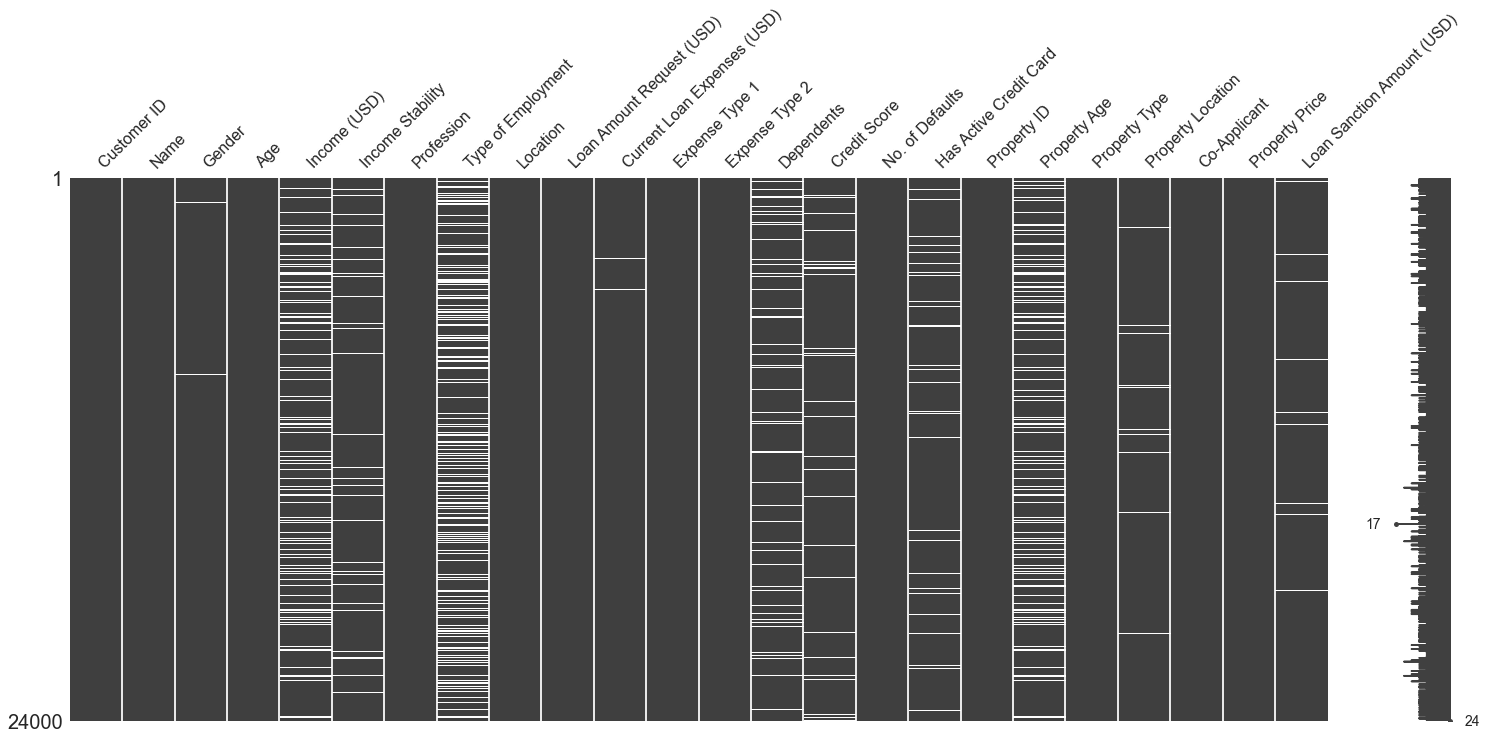

In [172]:
msno.matrix(loan_amt_train_copy)
plt.show()

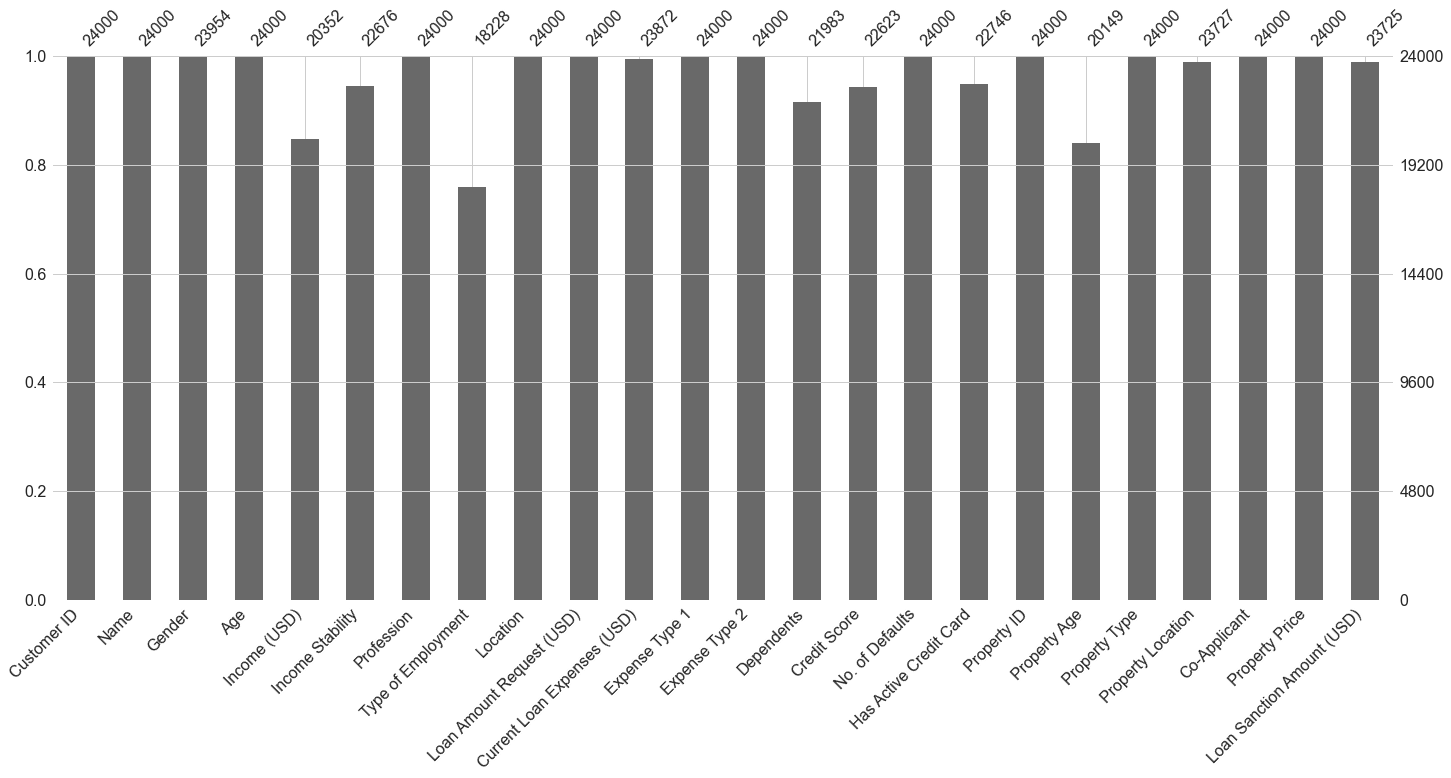

In [173]:
msno.bar(loan_amt_train_copy)
plt.show()

## 2.2 Functions used in the EDA of each feature

In [174]:
def value_cnt_norm_cal(df,feature):
    '''
    Function that will return the value count and frequency of each observation within a feature
    '''
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [175]:
def gen_info_feat(df,feature):
    '''
    function to create display general information about the feature
    '''
    match feature:
        case 'Age' | 'Income (USD)' | 'Loan Amount Request (USD)' | 'Current Loan Expenses (USD)' | 'Credit Score' | 'Property Age' | 'Property Price' | 'Loan Sanction Amount (USD)':
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Skewness:\n{}'.format(df[feature].skew()))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [176]:
def create_bar_plot(df,feature):
    '''
    function to create a bar chart plot
    '''
    match feature:
        case 'Profession' | 'Type of Employment' | 'Dependents':
            fig, ax = plt.subplots(figsize=(8,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0], color='dimgray')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.xticks(rotation=45,ha='right')
            plt.title('{} count'.format(feature))
            return plt.show()

In [177]:
def create_donnut_pie_chart(df,feature):
    '''
    function to create a donnut pie chart
    '''
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(8,8))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
    plt.title('Pie chart of {}'.format(feature))
    plt.legend(loc='best')
    plt.axis('equal')
    # add a circle at the center to transform it in a donut chart
    circle=plt.Circle( (0,0), 0.8, color='white')
    p=plt.gcf()
    p.gca().add_artist(circle)
    return plt.show()

In [178]:
def create_box_plot(df,feature):
    '''
    function to create a box plot
    '''
    fig, ax = plt.subplots(figsize=(2,8))
    sns.boxplot(y=df[feature])
    plt.title('{} distribution(Boxplot)'.format(feature))
    return plt.show()

In [179]:
def create_hist_plot(df,feature, the_bins=50):
    '''
    function to create a histogram plot
    '''
    fig, ax = plt.subplots(figsize=(18,10))
    sns.histplot(df[feature],bins=the_bins,kde=True)
    plt.title('{} distribution'.format(feature))
    return plt.show()

In [180]:
def missing_val_norm(df,feature):
    feat_nan_count = df[feature].isnull().sum()
    rows_count = df.shape[0]
    return 'The percentage of missing rows is {:.2f} %'.format(feat_nan_count * 100 / rows_count)

## 2.3. Univariate analysis

### 2.3.1 Gender

In [181]:
gen_info_feat(loan_amt_train_copy,'Gender')

Description:
count     23954
unique        2
top           M
freq      12087
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
M  12087         50.459
F  11867         49.541


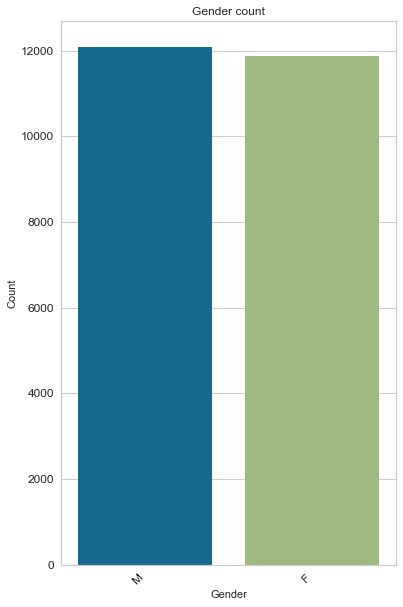

In [182]:
create_bar_plot(loan_amt_train_copy,'Gender')

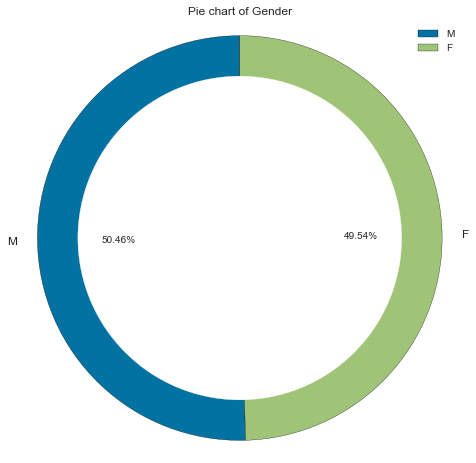

In [183]:
create_donnut_pie_chart(loan_amt_train_copy,'Gender')

Interpretation:
- We have almost the same number of Male vs Female (50.46% vs 49.54%)

### 2.3.2 Age

In [184]:
gen_info_feat(loan_amt_train_copy, 'Age')

Description:
count   24000.000
mean       40.058
std        16.029
min        18.000
25%        25.000
50%        40.000
75%        55.000
max        65.000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Skewness:
0.05019079901588933


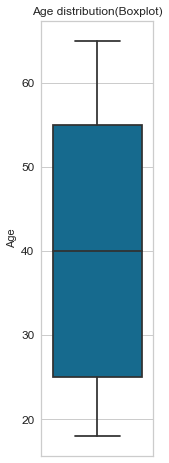

In [185]:
create_box_plot(loan_amt_train_copy, 'Age')

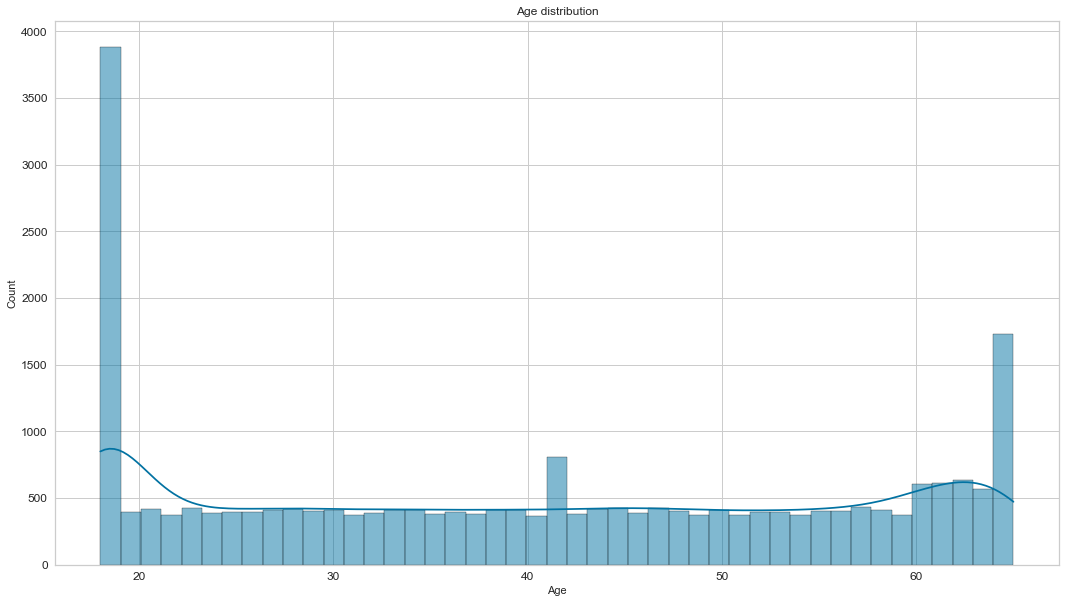

In [186]:
create_hist_plot(loan_amt_train_copy, 'Age', the_bins=45)

Interpretation:
- Age is not normally distributed
- We have a large number of applicants who are 18 and 65 years old
- Mean and median of age is 40 years old

### 2.3.3 Income

In [187]:
gen_info_feat(loan_amt_train_copy, 'Income (USD)')

Description:
count    20352.000
mean      2567.534
std       1775.075
min        378.760
25%       1652.707
50%       2229.965
75%       3092.775
max     122966.280
Name: Income (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
19.759160741711046


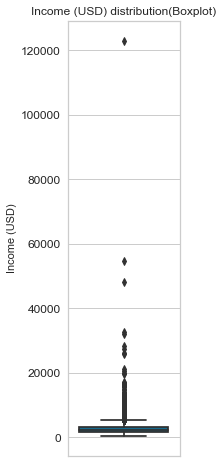

In [188]:
create_box_plot(loan_amt_train_copy, 'Income (USD)')

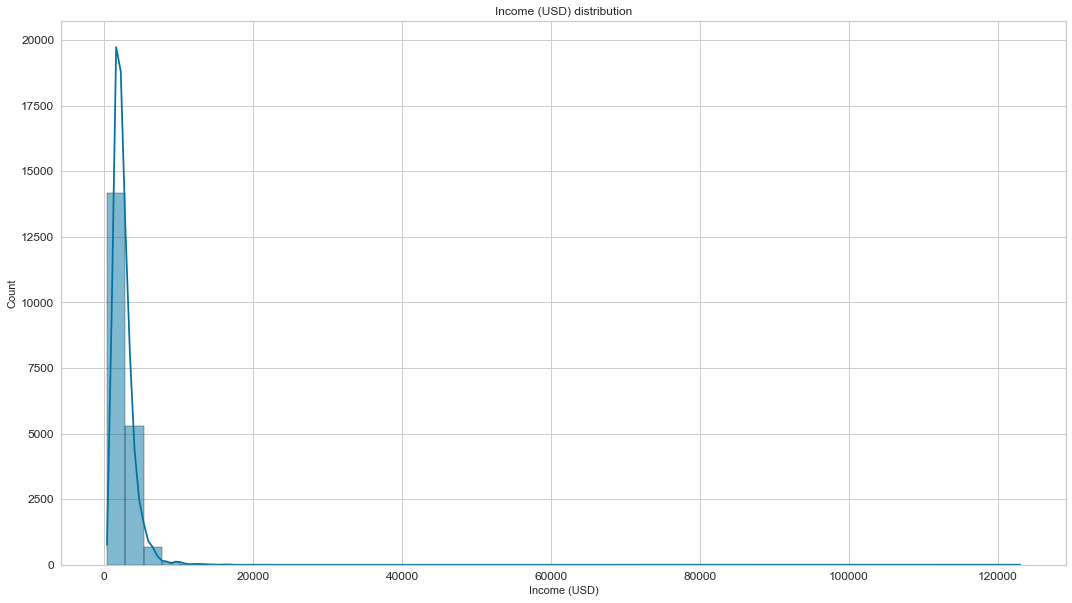

In [189]:
create_hist_plot(loan_amt_train_copy, 'Income (USD)', the_bins=50)

In [190]:
missing_val_norm(loan_amt_train_copy, 'Income (USD)')

'The percentage of missing rows is 15.20 %'

Interpretation:
- The Income feature has 15% of its data missing.
- The Income is positively skewed.
- The Income has a lot of outliers.
- The median income is $2229.

### 2.3.4 Income stability

In [191]:
gen_info_feat(loan_amt_train_copy,'Income Stability')

Description:
count     22676
unique        2
top         Low
freq      20617
Name: Income Stability, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
      Count  Frequency (%)
Low   20617         90.920
High   2059          9.080


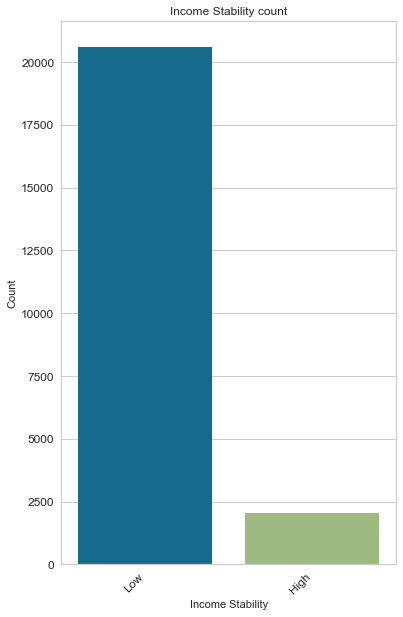

In [192]:
create_bar_plot(loan_amt_train_copy,'Income Stability')

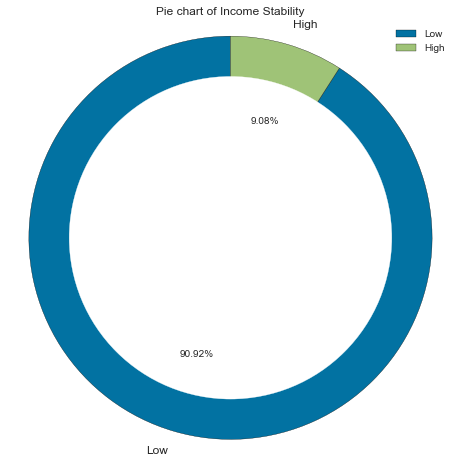

In [193]:
create_donnut_pie_chart(loan_amt_train_copy,'Income Stability')

Interpretation:
- Less than 10% of applicants have a high income stability
- 90% of applicants have a low income stability

### 2.3.5 Profession

In [194]:
gen_info_feat(loan_amt_train_copy,'Profession')

Description:
count       24000
unique          7
top       Working
freq        13509
Name: Profession, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Working               13509         56.288
Commercial associate   6433         26.804
Pensioner              2193          9.137
State servant          1861          7.754
Unemployed                2          0.008
Businessman               1          0.004
Student                   1          0.004


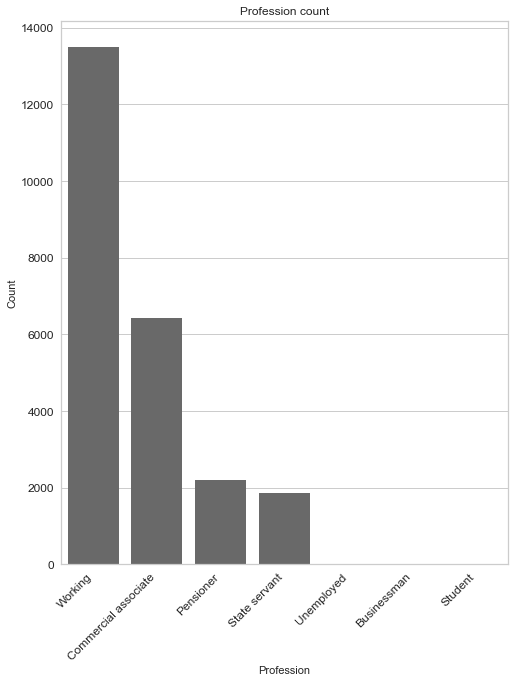

In [195]:
create_bar_plot(loan_amt_train_copy,'Profession')

Interpretation:
- Most applicants are currently working, the second most represented category is commercial associate.
- We also have a number of applicants that have pensioned and state servant.
- The most unrepresented category are the unemployed, businessman and student.

### 2.3.6 Type of employment

In [196]:
gen_info_feat(loan_amt_train_copy,'Type of Employment')

Description:
count        18228
unique          18
top       Laborers
freq          4495
Name: Type of Employment, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Laborers                4495         24.660
Sales staff             2997         16.442
Core staff              2605         14.291
Managers                1996         10.950
Drivers                 1273          6.984
Accountants             1096          6.013
High skill tech staff   1044          5.727
Medicine staff           669          3.670
Security staff           477          2.617
Cooking staff            446          2.447
Cleaning staff           283          1.553
Private service staff    280          1.536
Secretaries              132          0.724
Low-skill Laborers       125          0.686
Waiters/barmen staff     122          0.669
Realty agents             73    

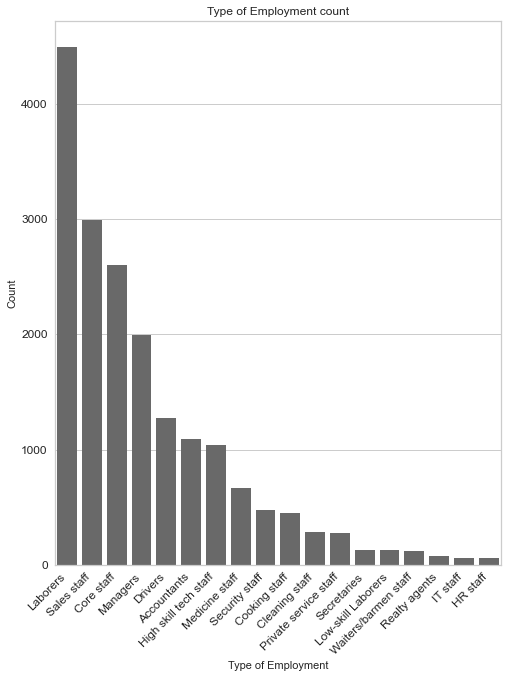

In [197]:
create_bar_plot(loan_amt_train_copy,'Type of Employment')

Interpretation:
- The most represented employment are laborers, sales staff, core staff and managers.
- The least represented employment are secretaries, low-skill laborers, waiters/barmen staff, realty agents, IT staff, HR staff.

### 2.3.7 Location

In [198]:
gen_info_feat(loan_amt_train_copy,'Location')

Description:
count          24000
unique             3
top       Semi-Urban
freq           17157
Name: Location, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Semi-Urban  17157         71.487
Rural        4320         18.000
Urban        2523         10.512


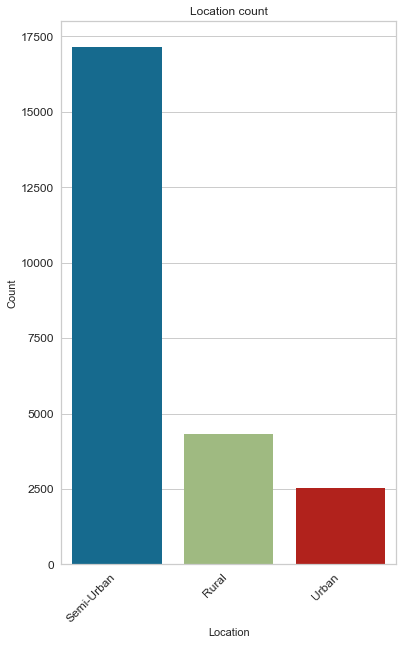

In [199]:
create_bar_plot(loan_amt_train_copy,'Location')

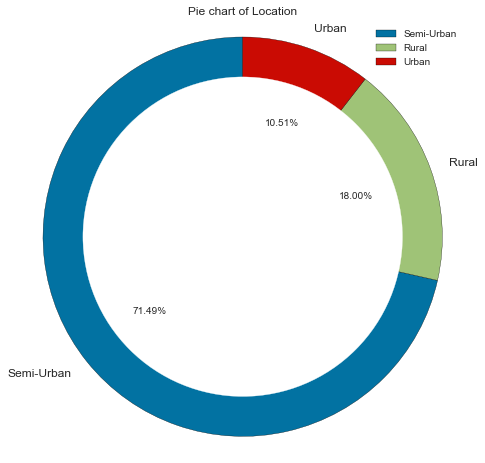

In [200]:
create_donnut_pie_chart(loan_amt_train_copy,'Location')

Interpretation:
- 7 out 10 applicants live in a semi-urban location
- Second most common location is the rural location
- Only 1 in 10 applicant live in an urban location

### 2.3.8 Loan Amount Request

In [201]:
gen_info_feat(loan_amt_train_copy,'Loan Amount Request (USD)')

Description:
count    24000.000
mean     89075.615
std      59637.687
min       6048.240
25%      41272.638
50%      75326.655
75%     120378.247
max     621497.820
Name: Loan Amount Request (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.2491353741072624


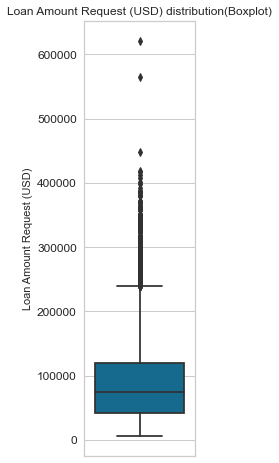

In [202]:
create_box_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

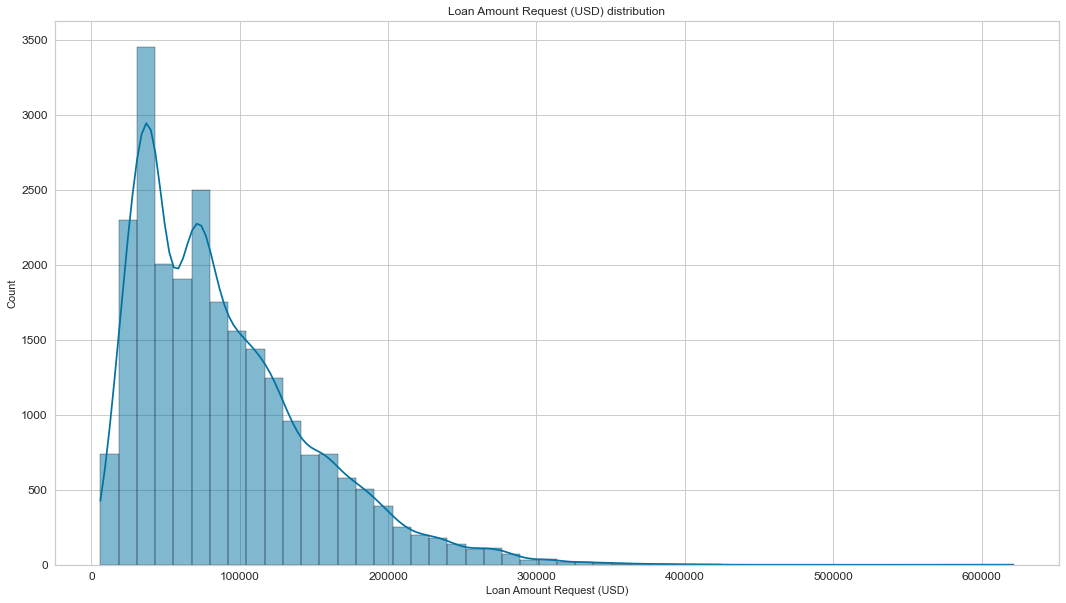

In [203]:
create_hist_plot(loan_amt_train_copy, 'Loan Amount Request (USD)')

Interpretation:
- The median of the loan amount request is $75326.655000
- We have quite a number of outliers in the loan amount request.
- The loan amount request distribution is positively skewed.

### 2.3.9 Current Loan Expenses

In [204]:
gen_info_feat(loan_amt_train_copy,'Current Loan Expenses (USD)')

Description:
count   23872.000
mean      401.409
std       241.893
min      -999.000
25%       248.933
50%       375.275
75%       521.215
max      3419.660
Name: Current Loan Expenses (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
-0.032881699548371904


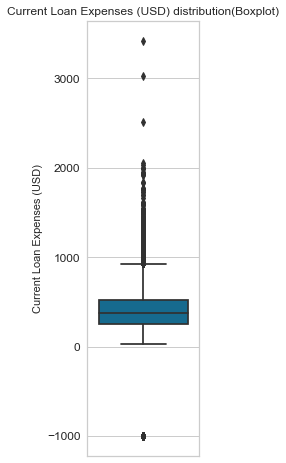

In [205]:
create_box_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

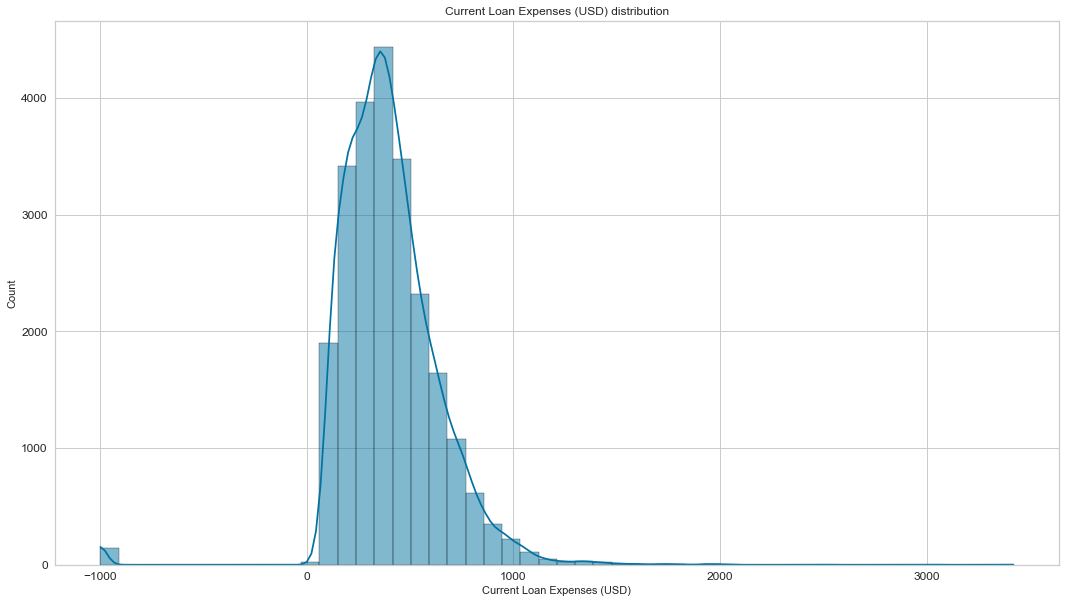

In [206]:
create_hist_plot(loan_amt_train_copy, 'Current Loan Expenses (USD)')

Interpretation:
- The mean current loan expenses is $375.275
- We have also some outliers
- The current loan expenses is positively skewed

### 2.3.10 Expense Type 1

In [207]:
gen_info_feat(loan_amt_train_copy,'Expense Type 1')

Description:
count     24000
unique        2
top           N
freq      15361
Name: Expense Type 1, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
N  15361         64.004
Y   8639         35.996


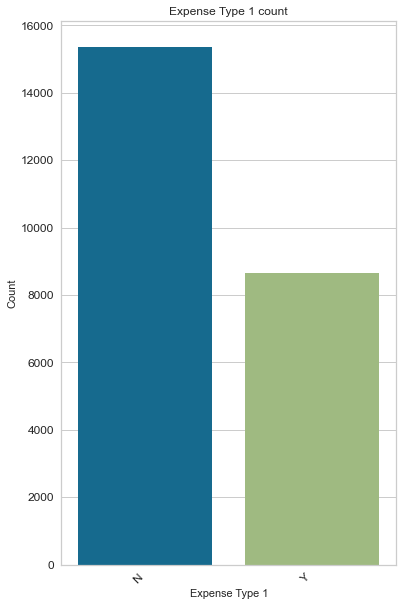

In [208]:
create_bar_plot(loan_amt_train_copy,'Expense Type 1')

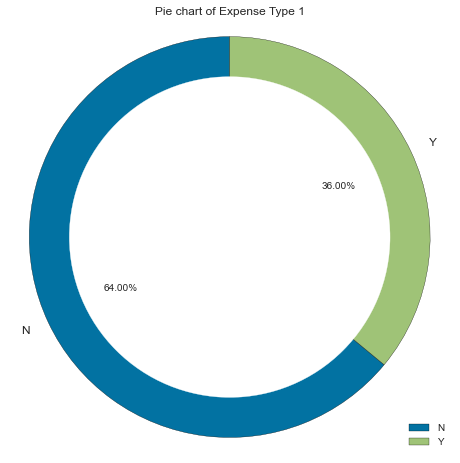

In [209]:
create_donnut_pie_chart(loan_amt_train_copy,'Expense Type 1')

Interpretation:
- More than half of applicants don't have the expenses type 1 on their loan.

### 2.3.11 Expense Type 2

In [210]:
gen_info_feat(loan_amt_train_copy,'Expense Type 2')

Description:
count     24000
unique        2
top           Y
freq      16116
Name: Expense Type 2, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
Y  16116         67.150
N   7884         32.850


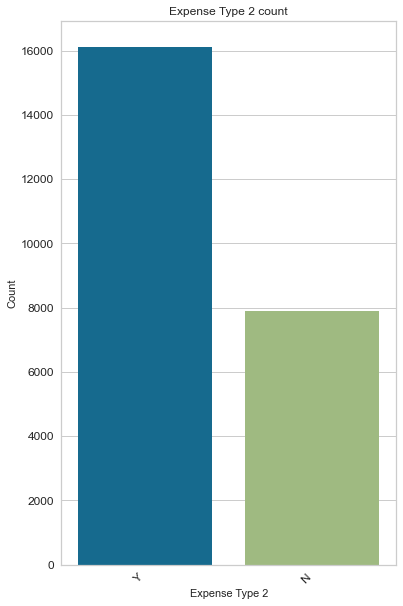

In [211]:
create_bar_plot(loan_amt_train_copy,'Expense Type 2')

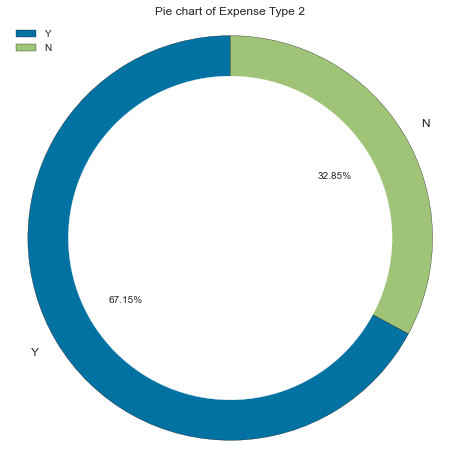

In [212]:
create_donnut_pie_chart(loan_amt_train_copy,'Expense Type 2')

Interpretation:
- The majority of applicants have expense type 2

### 2.3.12 Dependents

In [213]:
gen_info_feat(loan_amt_train_copy,'Dependents')

Description:
count   21983.000
mean        2.251
std         0.947
min         1.000
25%         2.000
50%         2.000
75%         3.000
max        10.000
Name: Dependents, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
        Count  Frequency (%)
2.000   10471         47.632
3.000    4568         20.780
1.000    4447         20.229
4.000    2160          9.826
5.000     293          1.333
6.000      37          0.168
7.000       5          0.023
8.000       1          0.005
10.000      1          0.005


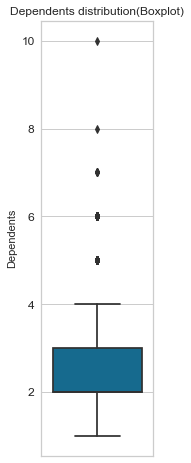

In [214]:
create_box_plot(loan_amt_train_copy, 'Dependents')

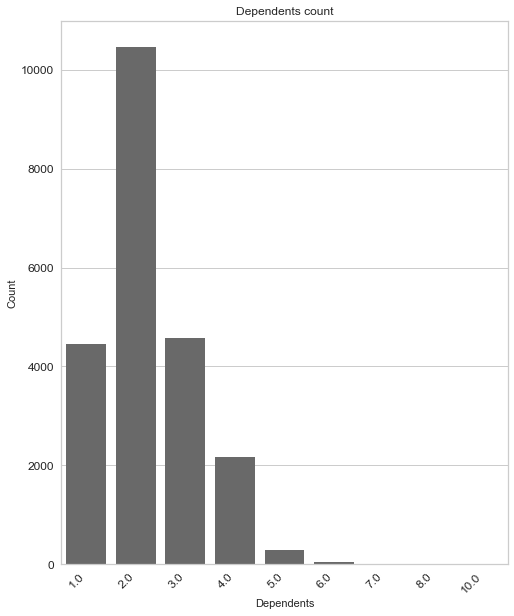

In [215]:
create_bar_plot(loan_amt_train_copy,'Dependents')

Interpretation:
- Most applicants have 2 dependents
- Then 1 and 3 dependents are the second most common
- Then 4 and 5 and so on

### 2.3.13 Credit Score

In [216]:
gen_info_feat(loan_amt_train_copy,'Credit Score')

Description:
count   22623.000
mean      739.727
std        72.272
min       580.000
25%       681.225
50%       739.880
75%       799.090
max       896.260
Name: Credit Score, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
-0.021671118190646724


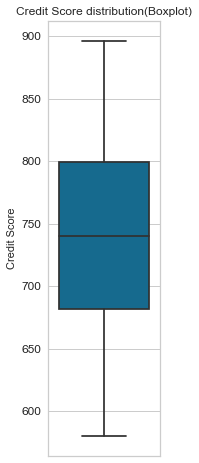

In [217]:
create_box_plot(loan_amt_train_copy, 'Credit Score')

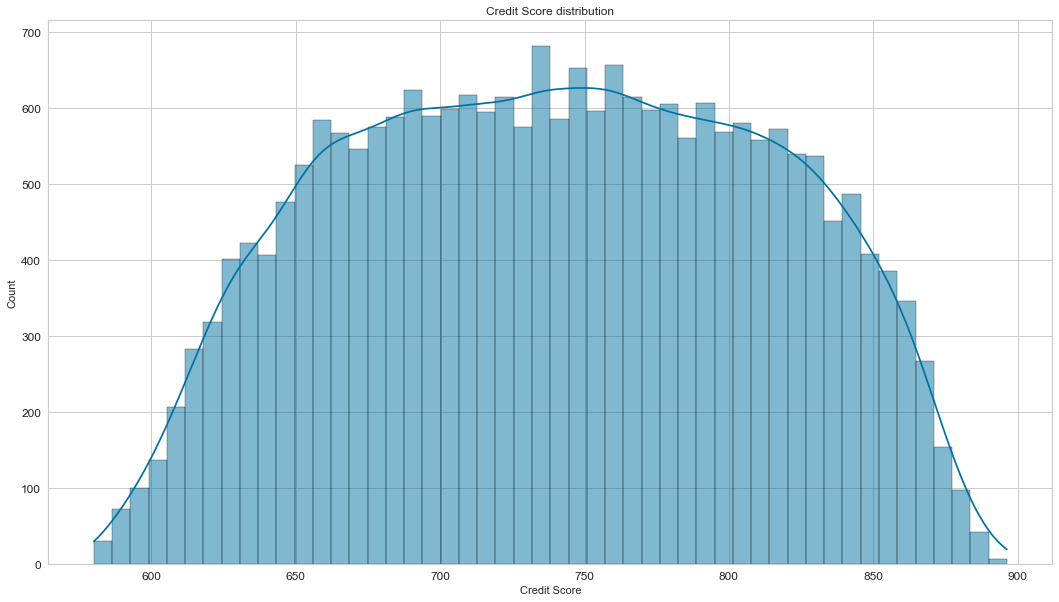

In [218]:
create_hist_plot(loan_amt_train_copy, 'Credit Score')

Interpretation:
- The mean and median of applicants's credit score is 739
- The credit score does not seems to be skewed but it is not normally distributed

### 2.3.14 Number of defaults

In [219]:
gen_info_feat(loan_amt_train_copy,'No. of Defaults')

Description:
count   24000.000
mean        0.194
std         0.395
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         1.000
Name: No. of Defaults, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  19347         80.612
1   4653         19.387


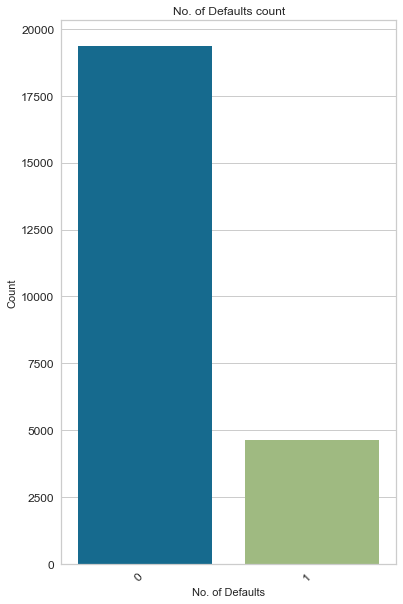

In [220]:
create_bar_plot(loan_amt_train_copy,'No. of Defaults')

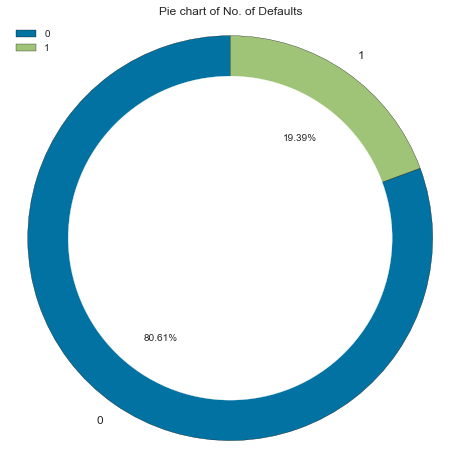

In [221]:
create_donnut_pie_chart(loan_amt_train_copy,'No. of Defaults')

Interpretation:
- 8 of 10 people don't have a any loan defaulted.

### 2.3.15 Has Active Credit Card

In [222]:
gen_info_feat(loan_amt_train_copy,'Has Active Credit Card')

Description:
count      22746
unique         3
top       Active
freq        7799
Name: Has Active Credit Card, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
             Count  Frequency (%)
Active        7799         34.287
Inactive      7620         33.500
Unpossessed   7327         32.212


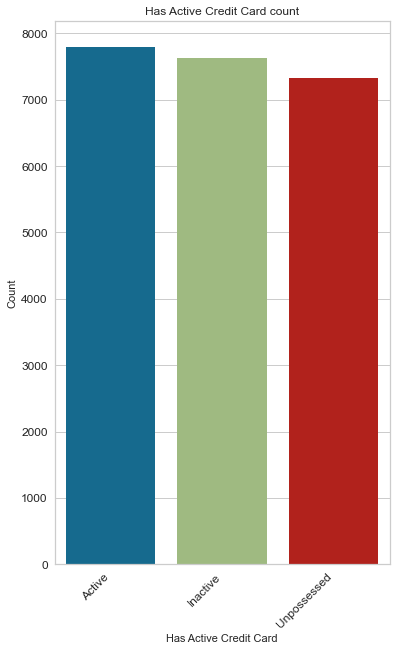

In [223]:
create_bar_plot(loan_amt_train_copy,'Has Active Credit Card')

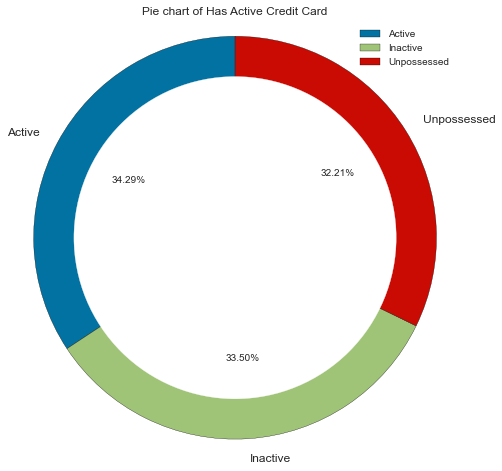

In [224]:
create_donnut_pie_chart(loan_amt_train_copy,'Has Active Credit Card')

Interpretation:
- We have almost an equal amount of people with an active, inactive and unpossessed credit card.

### 2.3.16 Property Age

In [225]:
gen_info_feat(loan_amt_train_copy,'Property Age')

Description:
count    20149.000
mean      2567.841
std       1776.813
min        378.760
25%       1653.040
50%       2231.100
75%       3094.050
max     122966.280
Name: Property Age, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
19.882898494886184


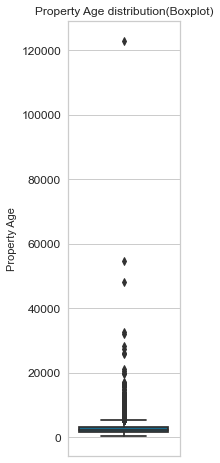

In [226]:
create_box_plot(loan_amt_train_copy, 'Property Age')

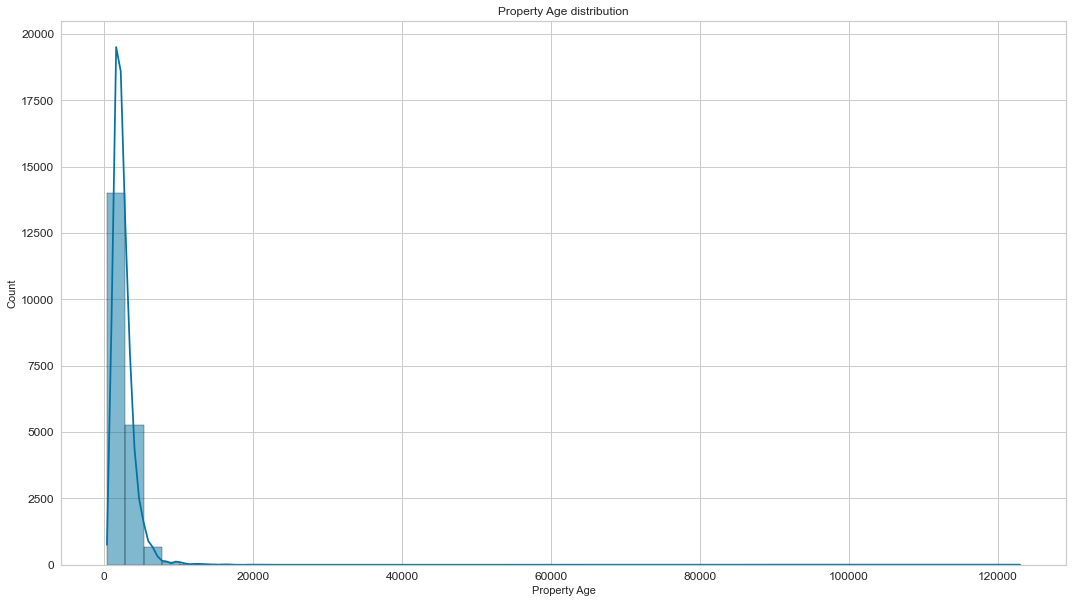

In [227]:
create_hist_plot(loan_amt_train_copy, 'Property Age')

Interpretation:
- Assuming that the property age is expressed in days, most of properties have a median age of 2231 days(6.1 years)
- The property age distribution is positively skewed


### 2.3.17 Property Type

In [228]:
gen_info_feat(loan_amt_train_copy,'Property Type')

Description:
count   24000.000
mean        2.464
std         1.121
min         1.000
25%         1.000
50%         2.000
75%         3.000
max         4.000
Name: Property Type, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
1   6304         26.267
2   6054         25.225
3   5851         24.379
4   5791         24.129


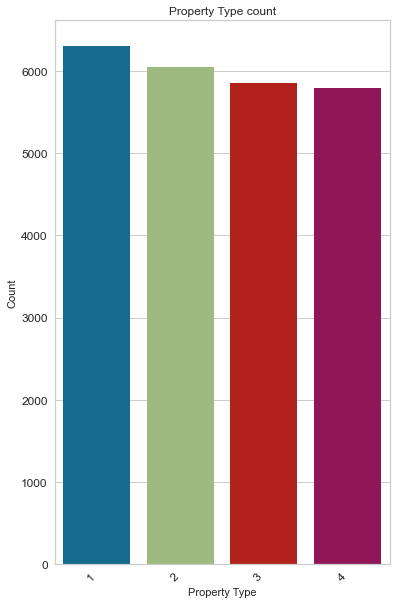

In [229]:
create_bar_plot(loan_amt_train_copy,'Property Type')

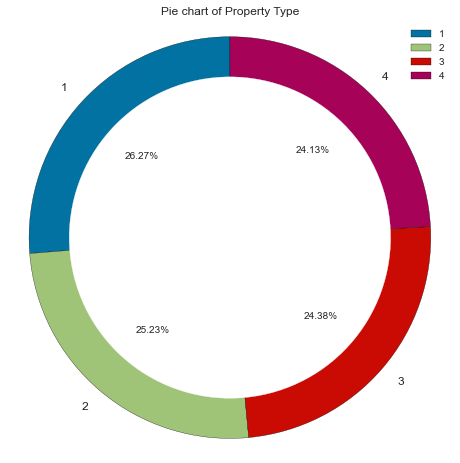

In [230]:
create_donnut_pie_chart(loan_amt_train_copy,'Property Type')

Interpretation:
- We have almost an equal amount of property types, each with 25%

### 2.3.18 Property Location

In [231]:
gen_info_feat(loan_amt_train_copy,'Property Location')

Description:
count          23727
unique             3
top       Semi-Urban
freq            8277
Name: Property Location, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Semi-Urban   8277         34.884
Rural        8060         33.970
Urban        7390         31.146


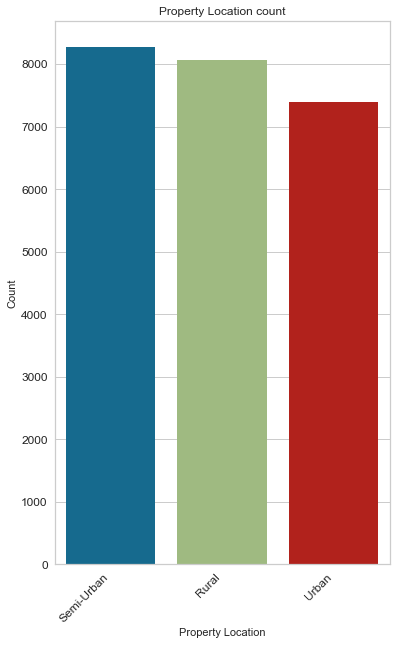

In [232]:
create_bar_plot(loan_amt_train_copy,'Property Location')

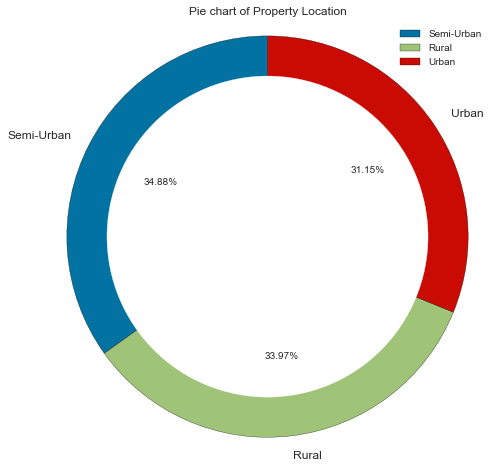

In [233]:
create_donnut_pie_chart(loan_amt_train_copy,'Property Location')

Interpretation:
- All the 3 property location are almost equally distributed at around 33%

### 2.3.19 Co-Applicant

In [234]:
gen_info_feat(loan_amt_train_copy,'Co-Applicant')

Description:
count   24000.000
mean       -4.686
std        74.227
min      -999.000
25%         1.000
50%         1.000
75%         1.000
max         1.000
Name: Co-Applicant, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
      Count  Frequency (%)
 1    20395         84.979
 0     3472         14.467
-999    133          0.554


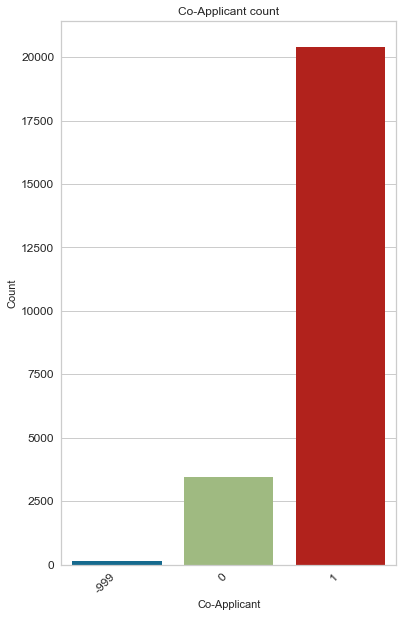

In [235]:
create_bar_plot(loan_amt_train_copy,'Co-Applicant')

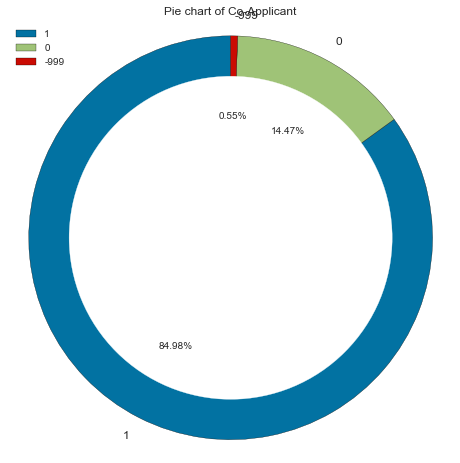

In [236]:
create_donnut_pie_chart(loan_amt_train_copy,'Co-Applicant')

Interpretation:
- Most of applicants have a co-applicants (~85%)
- 14% of applicants don't have a co-applicant
- The rest are unknown (~0.5%)

### 2.3.20 Property Price

In [237]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
gen_info_feat(loan_amt_train_copy,'Property Price')

Description:
count     24000.000
mean     132018.284
std       93566.244
min        -999.000
25%       60793.940
50%      110168.710
75%      179084.020
max     1077966.730
Name: Property Price, dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.3990671454033115


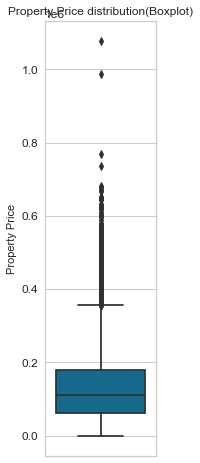

In [238]:
create_box_plot(loan_amt_train_copy, 'Property Price')

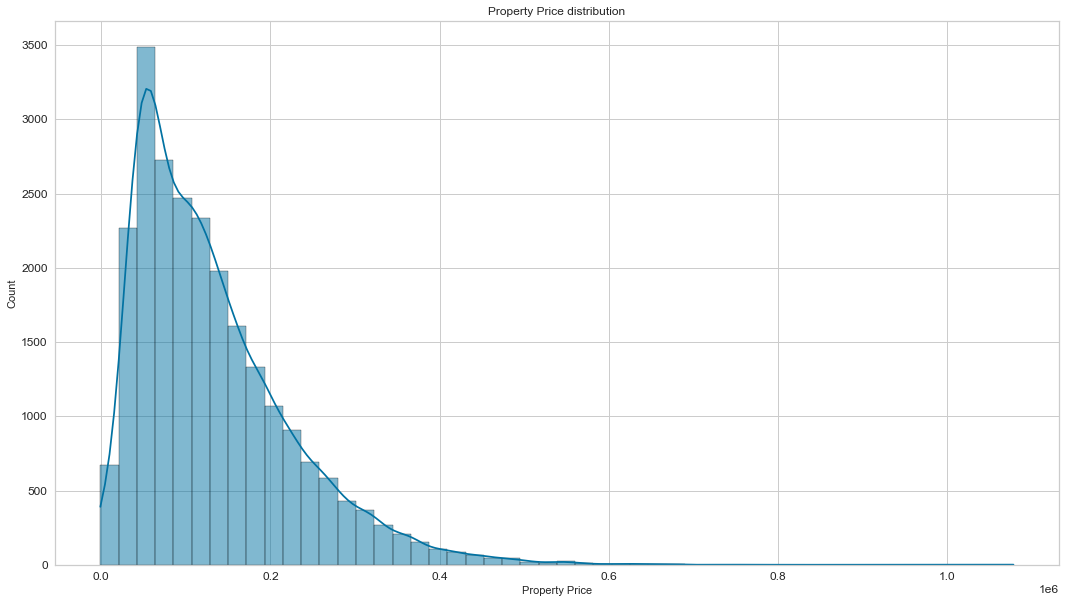

In [239]:
create_hist_plot(loan_amt_train_copy, 'Property Price')

Interpretation:
- The median property price is $110168.710
- We have quite a number of outliers
- The distribution of the property price is skewed to the right

### 2.3.21 Loan Sanction Amount

In [240]:
gen_info_feat(loan_amt_train_copy,'Loan Sanction Amount (USD)')

Description:
count    23725.000
mean     47680.600
std      48224.125
min       -999.000
25%          0.000
50%      35273.020
75%      74217.940
max     395368.740
Name: Loan Sanction Amount (USD), dtype: float64
**************************************************
Object type:
float64
**************************************************
Skewness:
1.2072630197126766


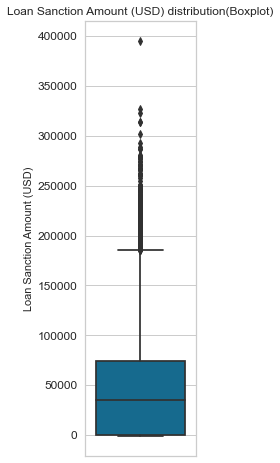

In [241]:
create_box_plot(loan_amt_train_copy, 'Loan Sanction Amount (USD)')

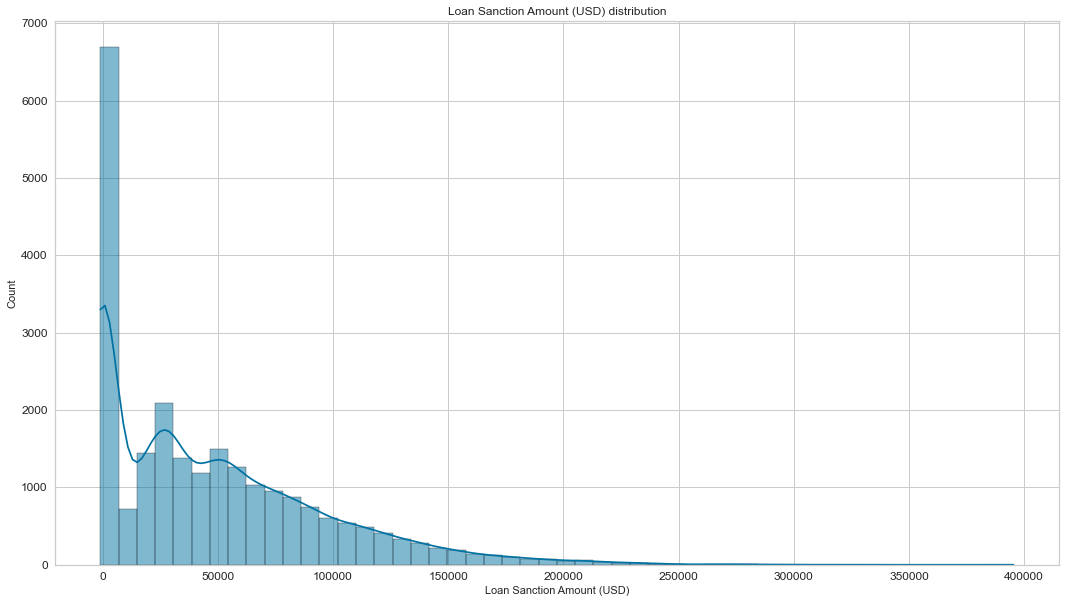

In [242]:
create_hist_plot(loan_amt_train_copy, 'Loan Sanction Amount (USD)')

Interpretation:
- The median loan sanction amount is $35273.020
- We have quite a number of outliers
- The distribution of the loan sanction amount is skewed to the right

## 2.4 Bivariate Analysis

### 2.4.1 Numerical vs numerical features (Correlation & scatter plots)

#### 2.4.1.1 Scatter plots

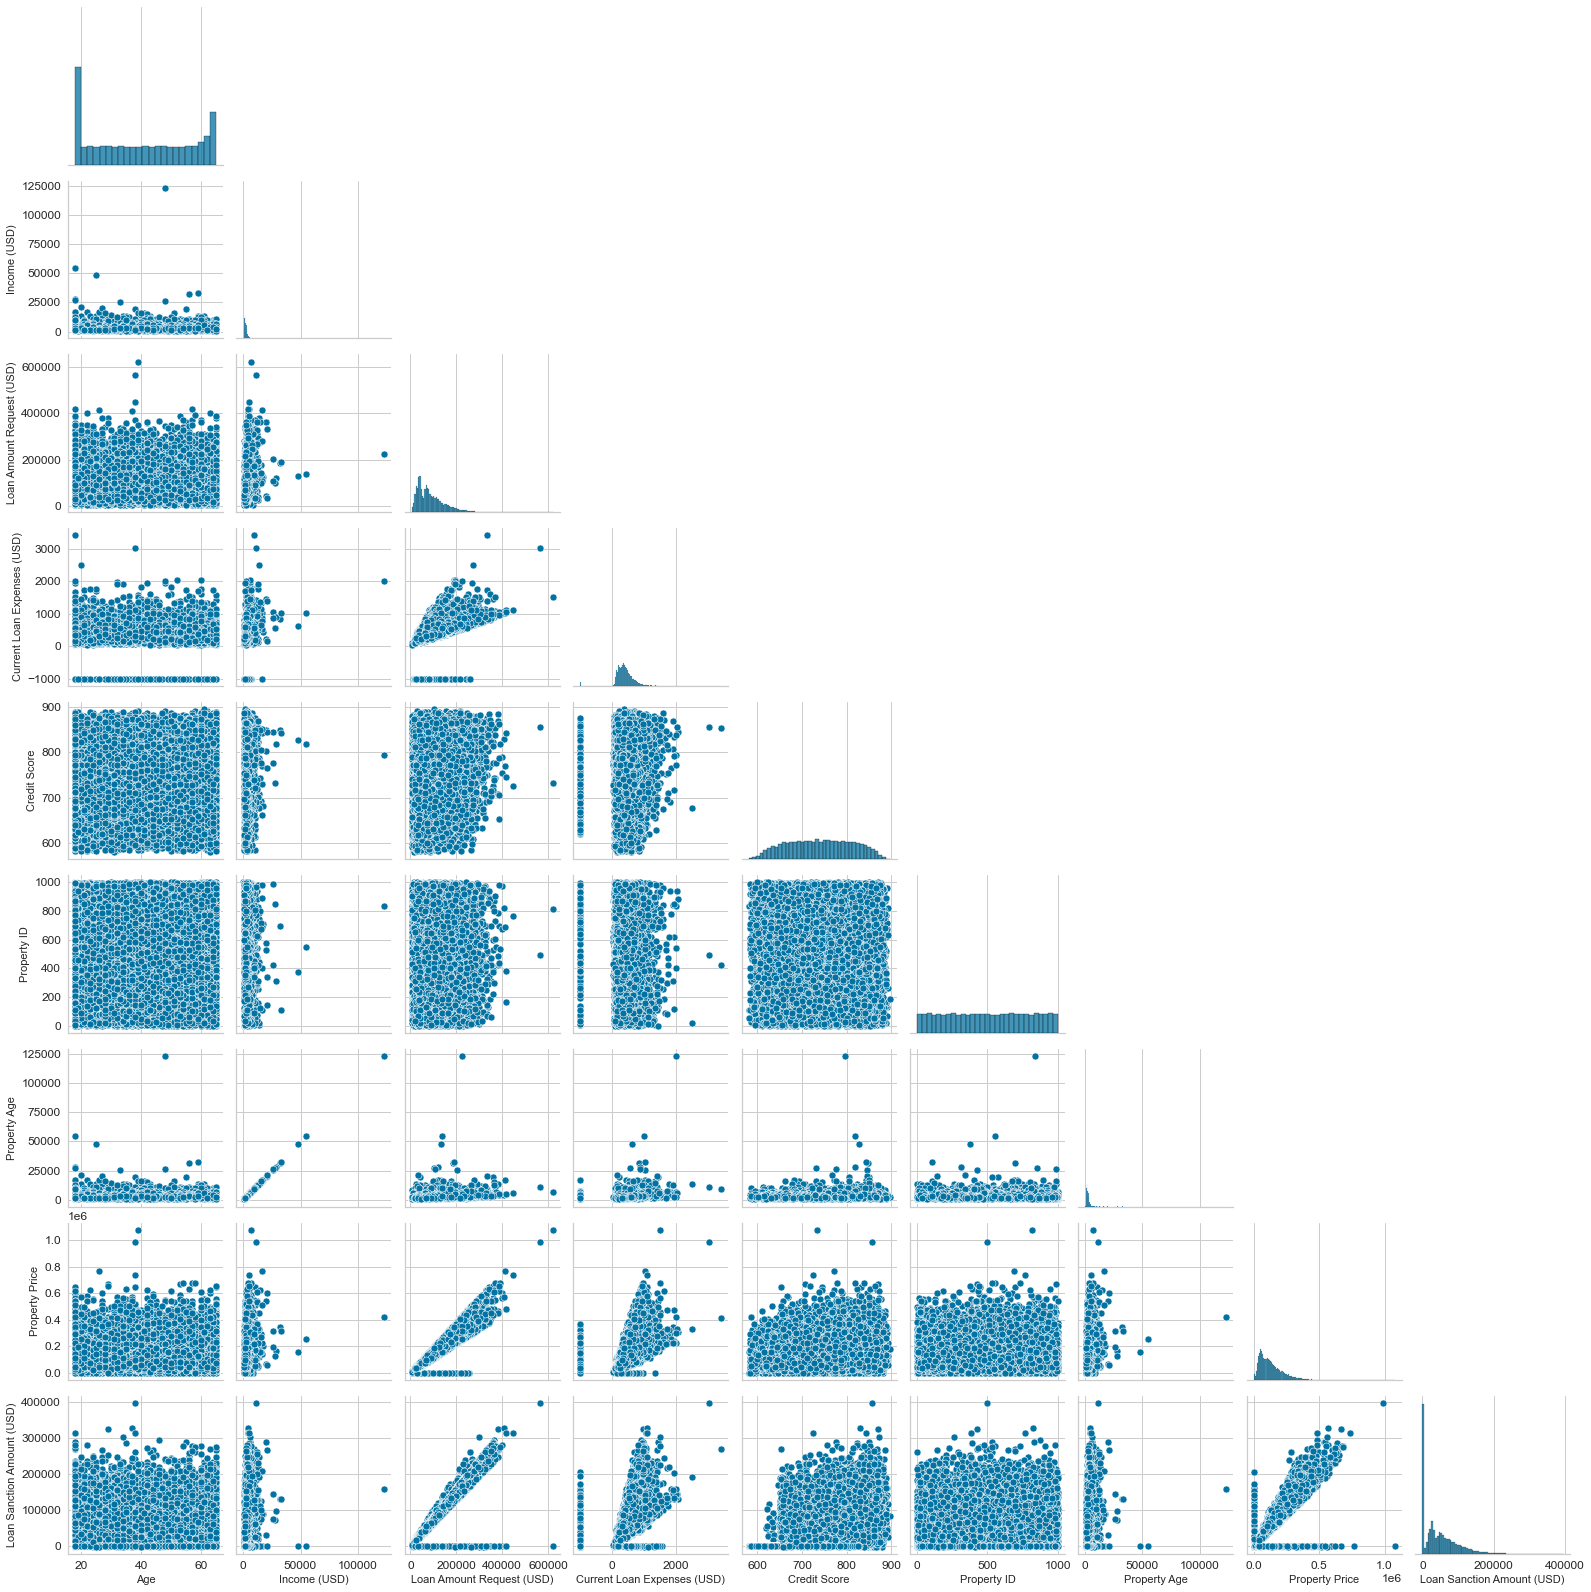

In [243]:
sns.pairplot(loan_amt_train_copy.drop(['Dependents','No. of Defaults','Property Type','Co-Applicant'],axis=1),corner=True)
plt.show()

Interpretation:
- There is a positive correlation between the loan amount request and the current loan expenses.
- There is also a perfect positive correlation between the income and the property age.
- There is a colleration between property price and loan amount request.
- There is a colleration between loan sanction amount and loan amount request.
- We also find a correlation between the property price and current loan expenses.
- There is a correlation between loan sanction amount and current loan expenses.
- There is a correlation between property price and loan sanction amount.

In [244]:
loan_amt_train_copy[['Loan Amount Request (USD)','Loan Sanction Amount (USD)']]

,Loan Amount Request (USD),Loan Sanction Amount (USD)
0,294604.890,235683.910
1,132263.080,0.000
2,112307.540,72999.900
3,24268.350,0.000
4,76342.040,57256.530
...,...,...
23995,122864.440,86005.110
23996,101151.000,65748.150
23997,91833.600,64283.520
23998,62065.250,43445.680


##### 2.4.1.1.1 Loan amount request vs current loan expenses

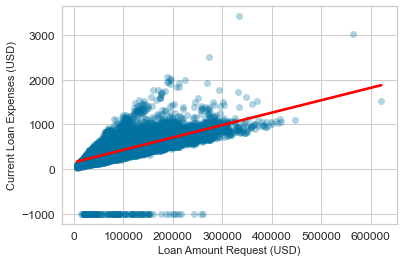

In [245]:
sns.regplot(x='Loan Amount Request (USD)',y='Current Loan Expenses (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The more the loan amount requested, the more the current loan expenses.

##### 2.4.1.1.2 Income vs property age

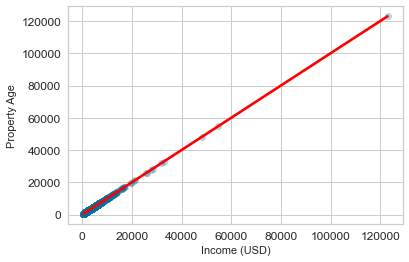

In [246]:
sns.regplot(x='Income (USD)',y='Property Age',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- We have a perfect correlation between the income and the property age. The more the income, the older the property.

##### 2.4.1.1.3 Loan amount request vs property price

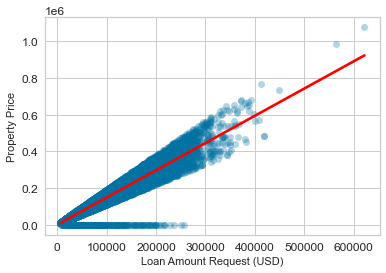

In [247]:
sns.regplot(x='Loan Amount Request (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The more amount of loan requested, the more expensive the property price.

##### 2.4.1.1.4 Loan amount request vs loan sanction amount

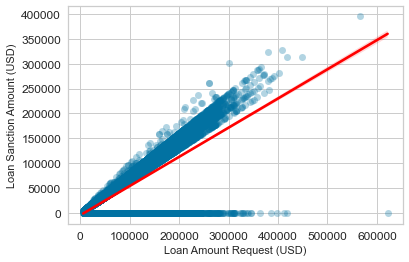

In [248]:
sns.regplot(x='Loan Amount Request (USD)',y='Loan Sanction Amount (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The loan amount requested increase with the loan sanction amount

##### 2.4.1.1.5 Current loan expenses vs Property price

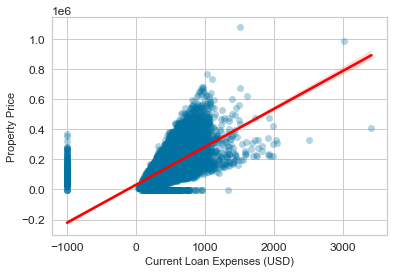

In [249]:
sns.regplot(x='Current Loan Expenses (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- Loan expenses generally increases with the property price.

##### 2.4.1.1.6 Current loan expenses vs Loan sanctioned amount

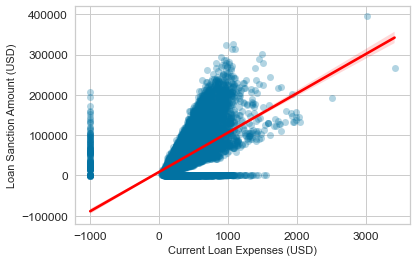

In [250]:
sns.regplot(x='Current Loan Expenses (USD)',y='Loan Sanction Amount (USD)',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- The loan expenses increase as the loan sanction amount increases.

##### 2.4.1.1.7 Property price vs loan sanction amount

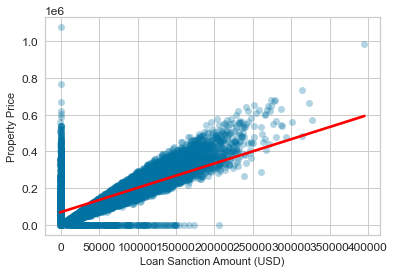

In [251]:
sns.regplot(x='Loan Sanction Amount (USD)',y='Property Price',data=loan_amt_train_copy,line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.show()

Interpretation:
- Loan sanction amount and the property price are positively correlated.

#### 2.4.1.2 Correlation analysis

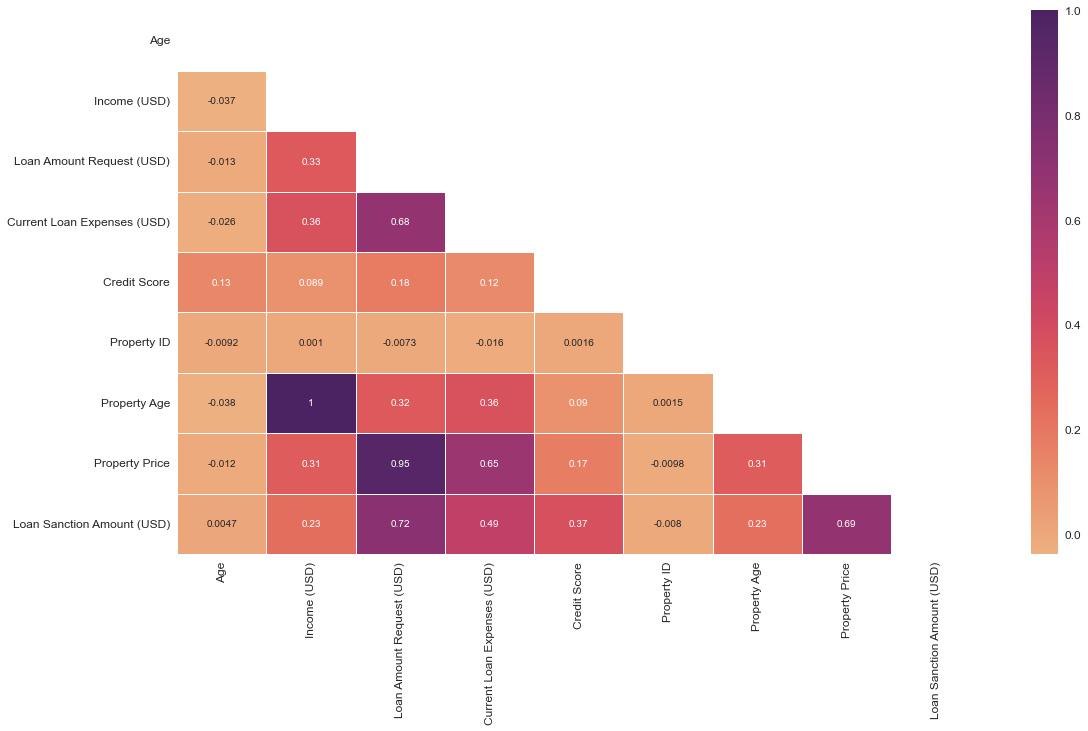

In [252]:
loan_amt_train_copy_corr = loan_amt_train_copy.drop(['Dependents','No. of Defaults','Property Type','Co-Applicant'],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(loan_amt_train_copy_corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(loan_amt_train_copy_corr, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

Interpretation:
- Income is highly correlated with Property age
- Loan Amount Request is highly correlated with Property Price
- Loan Amount Request is highly correlated with Loan Sanction Amount
- Current Loan Expenses is correlated with Property Price
- Current Loan Expenses is correlated with Loan Sanction Amount
- Loan Sanction Amount is highly correlated with Property Price


In [253]:
loan_amt_train_copy.columns

Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')

In [254]:
loan_amt_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  24000 non-null  object 
 1   Name                         24000 non-null  object 
 2   Gender                       23954 non-null  object 
 3   Age                          24000 non-null  int64  
 4   Income (USD)                 20352 non-null  float64
 5   Income Stability             22676 non-null  object 
 6   Profession                   24000 non-null  object 
 7   Type of Employment           18228 non-null  object 
 8   Location                     24000 non-null  object 
 9   Loan Amount Request (USD)    24000 non-null  float64
 10  Current Loan Expenses (USD)  23872 non-null  float64
 11  Expense Type 1               24000 non-null  object 
 12  Expense Type 2               24000 non-null  object 
 13  Dependents      

#### 2.4.2 Numerical vs categorical features (ANOVA)

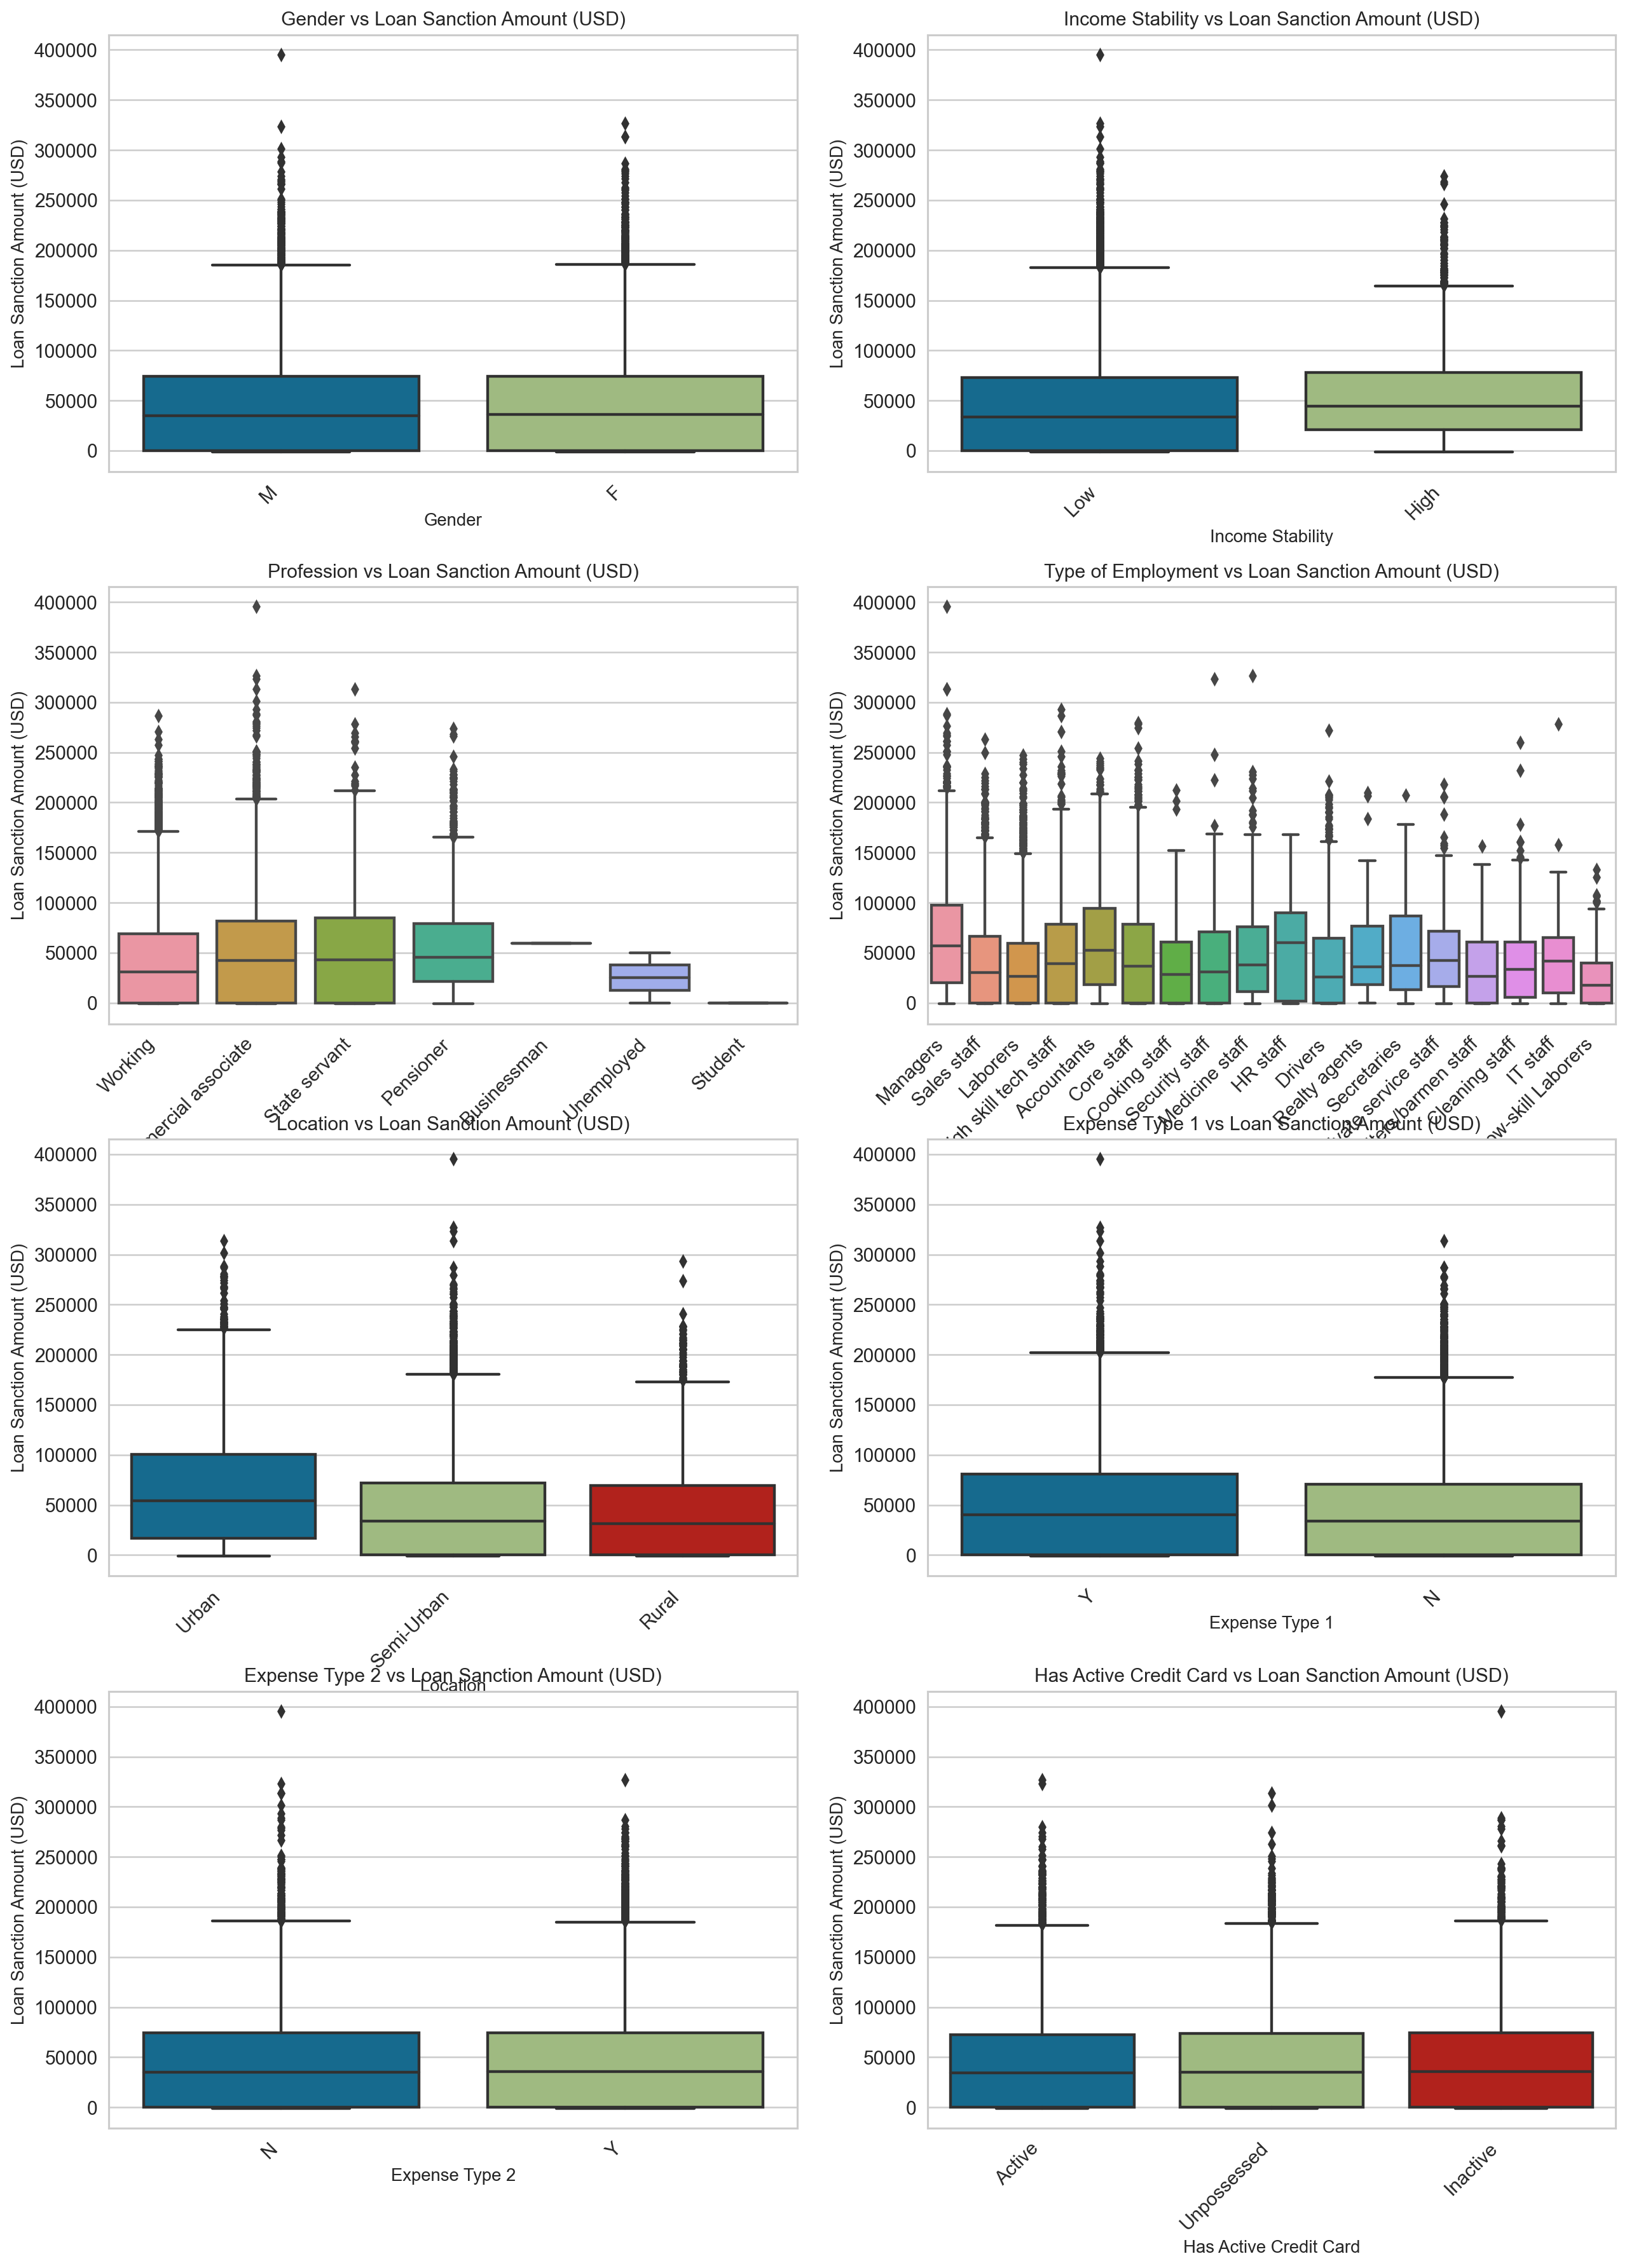

In [255]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender','Income Stability','Profession','Type of Employment','Location','Expense Type 1','Expense Type 2','Has Active Credit Card','Property Location']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=loan_amt_train_copy[cat_features[cat_ft_count]],y=loan_amt_train_copy['Loan Sanction Amount (USD)'])
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs Loan Sanction Amount (USD)")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Loan Sanction Amount (USD)')
            cat_ft_count += 1
    break

Interpretation:
- People with high income stability were given a high loan sanction amount
- Managers, HR staff and accounts received a median loan sanction amount of $5000
- People who live in urban area received the highest loan sanction amount

# 3. Prepare the data

## 3.1 Transformations to be done on each feature

Customer ID:
- Drop the feature

Name:
- Drop the feature


Gender:
- One hot encoding
- Missing value(Replace with the mode)


Age:
-	Min-max enc

Income:
-	Min-max enc
-	Outliers handler
-	Missing value (Replace with median)
-   Fix skewness

Income stability:
-	One hot encoding
-	Missing value (replace with the mode)

Profession:
-	One hot encoding

Type of employment
-	Drop the feature

Location:
-	One hot encoding

Loan amount request:
-	Min-max enc
-	Outliers handler
-   Fix skewness

Current loan expenses:
-	-999 handler
-	Min-max enc
-	Outliers handler
-	Missing value (replace with median)
-   Fix skewness

Expenses type 1
-	One hot encoding

Expenses type 2
-	One hot encoding


Dependents:
-	Outliers handler
-   Missing value (replace with mode)

Credit score:
-	Min-max enc
-	Missing value (replace with the mean/median)

Number of default:
-	Nothing to do

Has an active credit card:
-	One hot encoding
-	Missing value (replace with mode)

Property ID:
-	Drop feature

Property age:
-	Min-max enc
-	Outlier handler
- 	Missing value (replace with the median)
-   Fix skewness

Property type:
-	Nothing

Property loc:
-	One hot encoding
-	Missing value (replace with mode)

Co- applicant:
-	-999 handler

Property price:
-	Min max
-	Outliers handler
-   Fix skewness

Loan sanction amount:
-	Missing value (Drop the rows)
-   -999 handler



## 3.2 Data Cleaning

### 3.2.1 Outliers imputer

In [256]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Property Age', 'Property Price']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 1.5 * IQR)) | (df[self.feat_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.2.2 Missing values imputer

In [257]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, mode_imputed_ft = ['Gender','Income Stability','Dependents','Has Active Credit Card','Property Location'], median_imputed_ft = ['Income (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age']):
        self.mode_imputed_ft = mode_imputed_ft
        self.median_imputed_ft = median_imputed_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.mode_imputed_ft + self.median_imputed_ft).issubset(df.columns)):
            # drop missing values in the target feature
            df.dropna(inplace=True, axis=0, subset=['Loan Sanction Amount (USD)'])
            # impute missing values with mode
            for ft in self.mode_imputed_ft:
                the_mode = df[ft].mode()[0]
                df[ft] = df[ft].fillna(the_mode)
            # impute missing values with median
            for ft in self.median_imputed_ft:
                the_median = df[ft].median()
                df[ft] = df[ft].fillna(the_median)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.2.3 Remove less frequent professions

In [348]:
class DropUncommonProfession(BaseEstimator, TransformerMixin):
    def __init__(self,profession_list = ['Student','Unemployed','Businessman']):
        self.profession_list = profession_list
    def fit(self,df):
        return self
    def transform(self,df):
        if ('Profession' in df.columns):
            df = df[~df['Profession'].isin(self.profession_list)]
            return df
        else:
            print("Profession feature is not in the dataframe")
            return df

## 3.3 Feature selection

### 3.3.1 Feature drop

In [258]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['Customer ID','Name','Type of Employment','Property ID']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

## 3.4 Feature transformation

### 3.4.1 -999 Value imputer

In [259]:
class ValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_999_val = ['Co-Applicant','Current Loan Expenses (USD)','Loan Sanction Amount (USD)']):
        self.feat_with_999_val = feat_with_999_val
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_999_val).issubset(df.columns)):
            for ft in self.feat_with_999_val:
                df[ft].replace(-999.000,0,inplace=True,regex=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.2 Min-Max scaling (with feature's names)

In [260]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property Age', 'Property Price']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.3 One hot encoding (with feature's name)

In [261]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Profession', 'Location', 'Expense Type 1', 'Expense Type 2', 'Has Active Credit Card', 'Property Location', 'Income Stability']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.4.4 Skewness Handler

In [262]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['Income (USD)','Loan Amount Request (USD)','Current Loan Expenses (USD)','Property Age', 'Property Type']):
        self.col_with_skewness = col_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.col_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.col_with_skewness] = np.cbrt(df[self.col_with_skewness])
            return df
        else:
            print('One or more skewed columns are not found')
            return df

## 3.5 Data Preprocessing

In [349]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('outlier remover', OutlierImputer()),
        ('drop uncommon profession', DropUncommonProfession()),
        ('missing value imputer', MissingValueImputer()),
        ('drop features', DropFeatures()),
        ('-999 value imputer', ValueImputer()),
        ('skewness handler', SkewnessHandler()),
        ('min max scaler', MinMaxWithFeatNames()),
        ('one hot encoder', OneHotWithFeatNames())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [264]:
pd.options.mode.chained_assignment = None
loan_amt_train_copy_prep = full_pipeline(loan_amt_train_copy)

In [265]:
loan_amt_train_copy_prep

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Student,Profession_Unemployed,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
1,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.383,0.554,0.747,0.721,1.000,0.209,1,0.554,1.442,1,0.703,0.000
2,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.723,0.554,0.685,0.752,1.000,0.400,0,0.554,1.260,1,0.444,72999.900
3,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.554,0.245,0.351,2.000,0.190,0,0.554,1.260,1,0.088,0.000
4,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.569,0.552,0.853,2.000,0.808,0,0.569,1.442,1,0.401,57256.530
5,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.694,0.625,0.934,2.000,0.573,0,0.694,1.260,1,0.410,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.511,0.523,0.544,0.795,3.000,0.066,1,0.523,1.260,1,0.388,0.000
23995,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.021,0.554,0.718,0.590,1.000,0.676,1,0.554,1.260,1,0.553,86005.110
23997,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.412,0.613,0.564,2.000,0.677,0,0.412,1.587,1,0.310,64283.520
23998,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.383,0.554,0.488,0.638,3.000,0.462,0,0.554,1.587,1,0.203,43445.680


In [266]:
X_loan_amt_train_prep, y_loan_amt_train_prep = loan_amt_train_copy_prep.loc[:, loan_amt_train_copy_prep.columns != 'Loan Sanction Amount (USD)'], loan_amt_train_copy_prep['Loan Sanction Amount (USD)']

In [267]:
X_loan_amt_train_prep

,Gender_F,Gender_M,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Student,Profession_Unemployed,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price
1,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.383,0.554,0.747,0.721,1.000,0.209,1,0.554,1.442,1,0.703
2,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.723,0.554,0.685,0.752,1.000,0.400,0,0.554,1.260,1,0.444
3,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.554,0.245,0.351,2.000,0.190,0,0.554,1.260,1,0.088
4,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.569,0.552,0.853,2.000,0.808,0,0.569,1.442,1,0.401
5,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.694,0.625,0.934,2.000,0.573,0,0.694,1.260,1,0.410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.511,0.523,0.544,0.795,3.000,0.066,1,0.523,1.260,1,0.388
23995,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.021,0.554,0.718,0.590,1.000,0.676,1,0.554,1.260,1,0.553
23997,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.412,0.613,0.564,2.000,0.677,0,0.412,1.587,1,0.310
23998,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.383,0.554,0.488,0.638,3.000,0.462,0,0.554,1.587,1,0.203


In [268]:
y_loan_amt_train_prep

1           0.000
2       72999.900
3           0.000
4       57256.530
5           0.000
           ...   
23994       0.000
23995   86005.110
23997   64283.520
23998   43445.680
23999   55597.380
Name: Loan Sanction Amount (USD), Length: 21480, dtype: float64

# 4. Short-list promising models

## 4.1 Model training

In [269]:
Regressors = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Elastic Net Regression': ElasticNet(random_state=42),
    'KNN Regression': KNeighborsRegressor(),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42),
    'AdaBoost Regression': AdaBoostRegressor(random_state=42),
    'Bagging Regression': BaggingRegressor(random_state=42),
    'Extra Trees Regression': ExtraTreesRegressor(random_state=42),
    'Kernel Ridge Regression': KernelRidge(),
    'Bayesian Ridge Regression': BayesianRidge(),
    'Stochastic Gradient Descent Regression': SGDRegressor(random_state=42),
    'SVM Regression': SVR(),
    'Gaussian Process Regression': GaussianProcessRegressor(random_state=42),
    'Neural Network Regression': MLPRegressor(random_state=42)
}

In [270]:
def fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    rmse_scores_path = Path('saved_models/{0}/rmse_{0}'.format(model_name))
    try:
        rmse_scores_path.resolve(strict=True)
    except FileNotFoundError:
        scores = cross_val_score(model, X_loan_amt_train_prep, y_loan_amt_train_prep, cv=3, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))
        joblib.dump(rmse_scores, 'saved_models/{0}/rmse_{0}'.format(model_name))
    else:
        rmse_scores = joblib.load('saved_models/{0}/rmse_{0}'.format(model_name))
        print('Score: {}'.format(rmse_scores))
        print('Mean score: {}'.format(rmse_scores.mean()))
        print('Standard deviation: {}'.format(rmse_scores.std()))

In [271]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}/'.format(model_name)):
        os.makedirs('saved_models/{}/'.format(model_name))

In [272]:
# loop over all the models
for model_name, model in Regressors.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model(model_name)
    # fit and score the model
    fit_score_model(model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)





----------------------  Linear Regression  ----------------------


Score: [2.65205392e+04 2.68750824e+04 9.25091649e+14]
Mean score: 308363882951896.2
Standard deviation: 436092385378844.8




----------------------  Ridge Regression  ----------------------


Score: [26525.26169763 26849.59825474 25581.3800044 ]
Mean score: 26318.746652255515
Standard deviation: 537.9471662994117




----------------------  Lasso Regression  ----------------------


Score: [26524.43043032 26851.88538265 25577.50649093]
Mean score: 26317.940767967677
Standard deviation: 540.3633810742301




----------------------  Elastic Net Regression  ----------------------


Score: [36940.48786417 36716.0636762  36580.19811839]
Mean score: 36745.58321958899
Standard deviation: 148.56138531472718




----------------------  KNN Regression  ----------------------


Score: [35000.77960755 35263.37219704 34745.06524196]
Mean score: 35003.072348851514
Standard deviation: 211.6041389284448




----------------------

## 4.2 Top 4 models

- Random Forest Regressor
- Gradient Boosting Regressor
- Extra Trees Regression
- Bagging Regression

# 5. Fine tuning the model

In [273]:
def feat_importance(model_trn, model_name):
    # change xtick font size
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    # top 10 most predictive features
    top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
    # top 10 least predictive features
    bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
    #change the figure size
    plt.figure(figsize=(10, 4))
    #change x label font size
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    top_10_feat.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
    # show the plot
    top_10_feat.show()
    print('\n')
    plt.figure(figsize=(10, 4))
    plt.xlabel('xlabel', fontsize=14)
    # Fit to get the feature importances
    bottom_10_feat.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
    # show the plot
    bottom_10_feat.show()
    print('\n')

In [274]:
def shap_ft_importance(model_name, model,X_loan_amt_train_prep,y_loan_amt_train_prep):
    # get the model
    model = model
    # fit the model
    model.fit(X_loan_amt_train_prep,y_loan_amt_train_prep)
    # load JS visualization code to notebook
    shap.initjs()
    # get the shap values
    shap_values = shap.TreeExplainer(model).shap_values(X_loan_amt_train_prep)
    # get the feature importance
    shap_ft_importance = shap.summary_plot(shap_values,features=X_loan_amt_train_prep,feature_names=X_loan_amt_train_prep.columns, show=False)
    plt.savefig('saved_final_models/{0}/shap_ft_importance_{0}.png'.format(model_name))


In [275]:
def train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep):
    trained_model_path = Path('saved_final_models/{0}/trained_{0}'.format(model_name))
    try:
        trained_model_path.resolve(strict=True)
    except FileNotFoundError:
        best_model_trn = best_model.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(best_model_trn, 'saved_final_models/{0}/trained_{0}'.format(model_name))
    else:
        best_model_trn = joblib.load('saved_final_models/{0}/trained_{0}'.format(model_name))
    return best_model_trn

In [276]:
def fine_tune_model(model_name,model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep):
    folder_check_model(model_name)
    rand_search_path = Path('saved_final_models/{0}/rand_search_{0}'.format(model_name))
    try:
        rand_search_path.resolve(strict=True)
    except FileNotFoundError:
        rand_search = RandomizedSearchCV(model, parameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=5, return_train_score=True)
        rand_search.fit(X_loan_amt_train_prep, y_loan_amt_train_prep)
        joblib.dump(rand_search, 'saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        print('*'*50)
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    else:
        rand_search = joblib.load('saved_final_models/{0}/rand_search_{0}'.format(model_name))
        best_model = rand_search.best_estimator_
        rand_res = rand_search.cv_results_
        for mean_score, params in zip(rand_res['mean_test_score'], rand_res['params']):
            print(np.sqrt(-mean_score), params)
    return best_model

In [277]:
def folder_check_model(model_name):
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_final_models/{}/'.format(model_name)):
        os.makedirs('saved_final_models/{}/'.format(model_name))

## 5.1 Random Forest Regression

In [310]:
parameters = [
    {'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
]

In [311]:
rand_forest_dict = {'Random Forest Regression': RandomForestRegressor(random_state=42)}

In [312]:
model_name, model = list(rand_forest_dict.keys())[0], list(rand_forest_dict.values())[0]

In [313]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

21576.58625312367 {'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
20746.82334755494 {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}
21942.119925931438 {'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}
21239.257474549704 {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
26195.599648331176 {'n_estimators': 1600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}
20614.55885403883 {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
21422.65285083658 {'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features'

In [314]:
best_rand_for_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


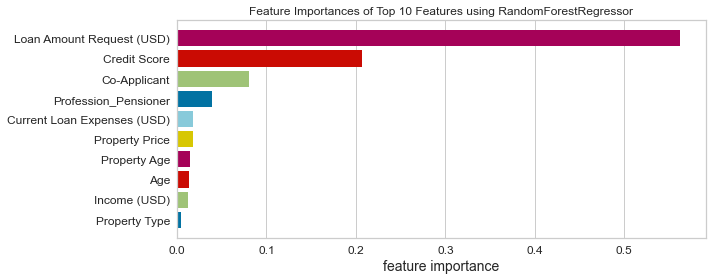

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


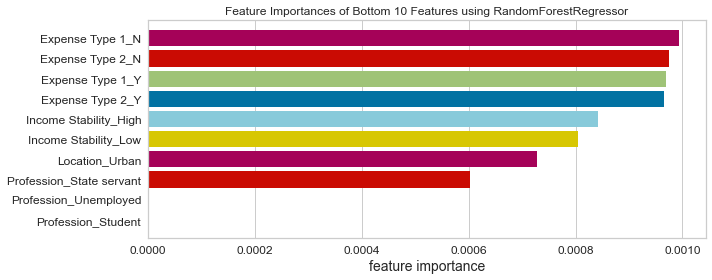

In [315]:
feat_importance(best_rand_for_trn, model_name)

## 5.2 Gradient Boosting Regression

In [316]:
parameters = [
    {
    'n_estimators':[5,50,100,250,500,1000,1500,2000],
    'max_depth':[1,3,5,7,9],
    'loss':['squared_error', 'absolute_error','huber','quantile'],
    'learning_rate':[0.0001,0.001,0.01,0.1,1,10],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features':['auto','sqrt'],
    }
]

In [317]:
grad_boost_dict = {'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42)}

In [318]:
model_name, model = list(grad_boost_dict.keys())[0], list(grad_boost_dict.values())[0]

In [319]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

71194.62868456995 {'n_estimators': 1500, 'min_samples_split': 5, 'min_samples_leaf': 0.30000000000000004, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'quantile', 'learning_rate': 0.0001}
40040.8151268876 {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 0.2, 'max_features': 'auto', 'max_depth': 9, 'loss': 'squared_error', 'learning_rate': 0.0001}
23514.123430980475 {'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 0.1, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'squared_error', 'learning_rate': 0.01}
40648.10087970159 {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 0.30000000000000004, 'max_features': 'sqrt', 'max_depth': 9, 'loss': 'squared_error', 'learning_rate': 0.0001}
30773.98846529185 {'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 0.30000000000000004, 'max_features': 'auto', 'max_depth': 1, 'loss': 'absolute_error', 'learning_rate': 0.1}
39737.50893061844 {'n_estimators': 2000, 'min_samples_split':

In [320]:
best_grad_boost_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


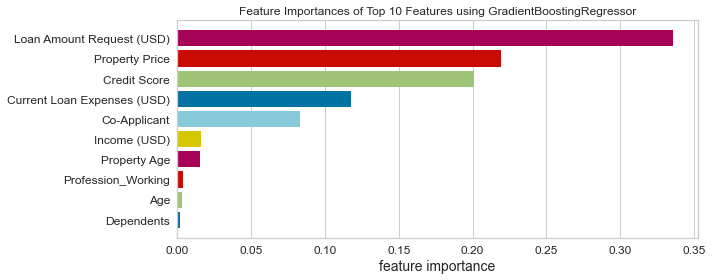

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


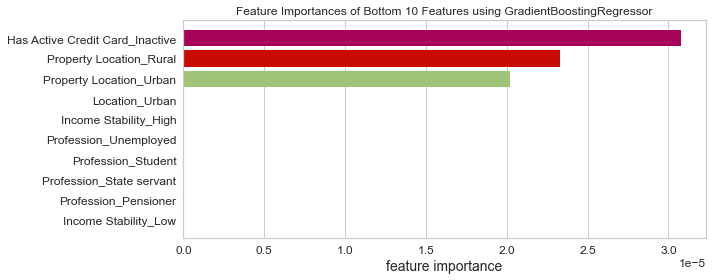

In [321]:
feat_importance(best_grad_boost_trn, model_name)

## 5.3 Extra Trees Regression

In [322]:
n_samples = X_loan_amt_train_prep.shape[0]
n_features = X_loan_amt_train_prep.shape[1]

parameters = [
    {
    'n_estimators': [10, 50, 100, 500, 1000, 2000],
    'max_depth': [None, 2,5,],
    'min_samples_split': [2, 0.5, n_samples//2, ],
    'min_samples_leaf': [1, 0.5, n_samples//2, ],
    'criterion': ['squared_error', 'absolute_error'],
    'max_features': [None, 'sqrt', 'auto', 'log2', 0.3, 0.5, n_features//2],
    'bootstrap':[True, False]
    }
]

In [323]:
extra_trees_dict = {'Extra Trees Regression': ExtraTreesRegressor(random_state=42)}

In [324]:
model_name, model = list(extra_trees_dict.keys())[0], list(extra_trees_dict.values())[0]

In [325]:
folder_check_model(model_name)

In [326]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

41988.705538315204 {'n_estimators': 1000, 'min_samples_split': 0.5, 'min_samples_leaf': 10740, 'max_features': 'log2', 'max_depth': None, 'criterion': 'absolute_error', 'bootstrap': False}
40800.777582639676 {'n_estimators': 100, 'min_samples_split': 10740, 'min_samples_leaf': 10740, 'max_features': 0.3, 'max_depth': 5, 'criterion': 'squared_error', 'bootstrap': True}
40800.86501818386 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 0.5, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'squared_error', 'bootstrap': False}
40800.777582639676 {'n_estimators': 100, 'min_samples_split': 0.5, 'min_samples_leaf': 10740, 'max_features': 17, 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': True}
41993.1726908286 {'n_estimators': 50, 'min_samples_split': 10740, 'min_samples_leaf': 0.5, 'max_features': 'auto', 'max_depth': 2, 'criterion': 'absolute_error', 'bootstrap': True}
41988.705538315226 {'n_estimators': 100, 'min_samples_split': 10740, 'min_samples_leaf'

In [327]:
best_extra_tree_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names


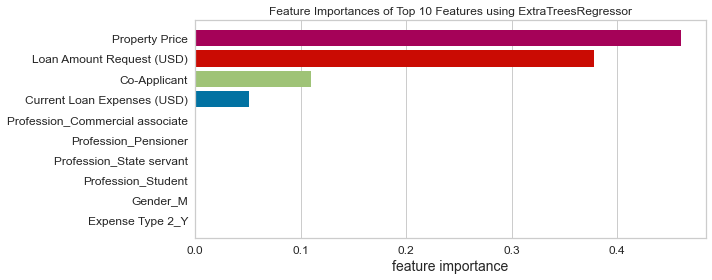

X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names


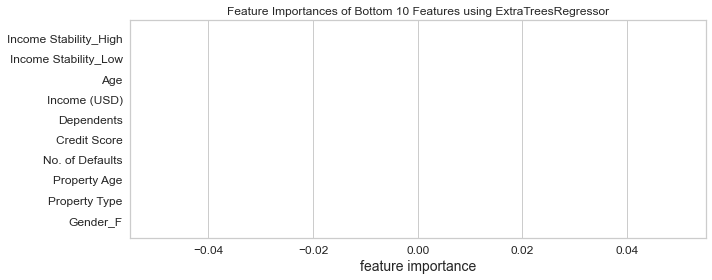

In [328]:
feat_importance(best_extra_tree_trn, model_name)

## 5.4 Bagging Regression

In [329]:
parameters = [
    {
    'base_estimator': [None, LinearRegression(), KNeighborsRegressor()],
    'n_estimators': [20,50,100],
    'max_samples': [0.5,1.0, n_samples//2,],
    'max_features': [0.5,1.0, n_features//2,],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
    }
]

In [330]:
bagging_reg_dict = {'Bagging Regression': BaggingRegressor(random_state=42)}

In [331]:
model_name, model = list(bagging_reg_dict.keys())[0], list(bagging_reg_dict.values())[0]

In [332]:
folder_check_model(model_name)

In [333]:
best_model = fine_tune_model(model_name, model, parameters, X_loan_amt_train_prep, y_loan_amt_train_prep)

28859.48509296681 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 17, 'bootstrap_features': True, 'bootstrap': True, 'base_estimator': KNeighborsRegressor()}
26048.7407899982 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.5, 'bootstrap_features': True, 'bootstrap': True, 'base_estimator': None}
5856478372810.664 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 17, 'bootstrap_features': False, 'bootstrap': True, 'base_estimator': LinearRegression()}
27980.992830203137 {'n_estimators': 20, 'max_samples': 0.5, 'max_features': 0.5, 'bootstrap_features': True, 'bootstrap': False, 'base_estimator': None}
1462616093468.0872 {'n_estimators': 50, 'max_samples': 1.0, 'max_features': 0.5, 'bootstrap_features': True, 'bootstrap': False, 'base_estimator': LinearRegression()}
29643.589311031705 {'n_estimators': 100, 'max_samples': 10740, 'max_features': 17, 'bootstrap_features': False, 'bootstrap': True, 'base_estimator': KNeighborsRegressor()}
12313324197342.475 {'n_

In [334]:
best_bagging_trn = train_model(best_model, model_name, X_loan_amt_train_prep, y_loan_amt_train_prep)

## 5.5 Final model

We did hyperparameter tuning for the top 4 models, but only the random forest regressor yield an improved score. We will use that model with those parameters.

In [335]:
best_rand_for_trn

RandomForestRegressor(max_depth=30, min_samples_leaf=4, n_estimators=1400,
                      random_state=42)

# 6. Test the final model on the test dataset

In [304]:
loan_amt_test_copy.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-25648,Necole Newbold,M,48,2631.710,Low,Working,Drivers,Semi-Urban,65466.320,519.540,Y,Y,4.000,646.630,0,Unpossessed,582,2631.710,3,Urban,1,72111.030,0.000
1,C-27924,Ranee Yager,F,58,4445.650,NaN,Commercial associate,Laborers,Urban,88846.600,392.920,Y,Y,3.000,701.170,0,Unpossessed,319,4445.650,1,Semi-Urban,1,106418.120,62192.620
2,C-27842,Ivory Toledo,M,25,1586.370,Low,Commercial associate,Sales staff,Semi-Urban,142786.480,479.470,N,Y,2.000,673.920,1,Inactive,109,1586.370,4,Urban,1,181177.470,99950.540
3,C-7269,Todd Turcios,F,18,NaN,Low,Commercial associate,Core staff,Semi-Urban,119311.640,433.590,N,Y,3.000,610.330,0,Inactive,267,NaN,2,Rural,1,213450.090,0.000
4,C-47464,Beatriz Lessman,F,36,1591.720,Low,Working,Sales staff,Semi-Urban,48373.340,241.160,N,Y,3.000,728.090,0,Unpossessed,641,1591.720,4,Rural,1,74100.660,0.000


## 6.1 Data preprocessing for the test set

In [152]:
loan_amt_test_copy_prep = full_pipeline(loan_amt_test_copy)

In [305]:
loan_amt_test_copy_prep

,Gender_F,Gender_M,Profession_Businessman,Profession_Commercial associate,Profession_Pensioner,Profession_State servant,Profession_Working,Location_Rural,Location_Semi-Urban,Location_Urban,Expense Type 1_N,Expense Type 1_Y,Expense Type 2_N,Expense Type 2_Y,Has Active Credit Card_Active,Has Active Credit Card_Inactive,Has Active Credit Card_Unpossessed,Property Location_Rural,Property Location_Semi-Urban,Property Location_Urban,Income Stability_High,Income Stability_Low,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.638,0.650,0.503,0.721,4.000,0.210,0,0.650,1.442,1,0.208,0.000
1,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.851,0.911,0.604,0.606,3.000,0.387,0,0.911,1.000,1,0.305,62192.620
2,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.149,0.438,0.781,0.687,2.000,0.298,1,0.438,1.587,1,0.517,99950.540
3,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.551,0.710,0.645,3.000,0.091,0,0.551,1.260,1,0.609,0.000
4,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.383,0.440,0.414,0.430,3.000,0.475,0,0.440,1.587,1,0.213,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.672,0.777,0.712,4.000,0.775,0,0.672,1.260,1,0.640,106164.560
5994,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.745,0.843,0.468,0.479,1.000,0.400,0,0.551,1.000,1,0.219,37951.710
5995,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.681,0.461,0.126,0.245,1.000,0.461,0,0.461,1.587,1,0.071,9736.100
5997,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.733,0.555,0.595,2.000,0.729,0,0.733,1.000,1,0.244,57763.880


In [306]:
X_loan_amt_test_prep, y_loan_amt_test_prep = loan_amt_test_copy_prep.loc[:, loan_amt_test_copy_prep.columns != 'Loan Sanction Amount (USD)'], loan_amt_test_copy_prep['Loan Sanction Amount (USD)']

## 6.2 Predicting Loan Sanction Amount on the Test Set

In [336]:
final_predictions = best_rand_for_trn.predict(X_loan_amt_test_prep)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Profession_Businessman
Feature names seen at fit time, yet now missing:
- Profession_Student
- Profession_Unemployed



ValueError: X has 33 features, but RandomForestRegressor is expecting 34 features as input.